# Подготовка данных

Датасеты были взяты с roboflow, в-одном было 10100 изображений(8080 на обучение и 2020 на валидацию), а во-втором 23774(20811 на обучение, 1973 на валидацию и 990 на тест). К каждому изобрвжеию прикреплелся файл, в котором находились классы наших мастей, а также рамки, где были сами масти карт. Задача состоит в том, чтобы извлечь эти рамки и классы, а затем добавить их в один файл формата .yaml(формат дынных для обучения модели YOLO). Выбрал модель YOLO, так как она хорошо подходит для детектирования в реальном времени. В train.yaml будут храниться данные для обучения(train) и валидации(valid). Также будет и test.yaml, чтобы проверить модель.

https://universe.roboflow.com/augmented-startups/playing-cards-ow27d

https://universe.roboflow.com/fh-cards/cards-and-such/dataset/1


In [ ]:
names = ['10C','10D','10H','10S',
         '2C','2D','2H','2S',
         '3C','3D','3H','3S',
         '4C','4D','4H','4S',
         '5C','5D','5H','5S',
         '6C','6D','6H','6S',
         '7C','7D','7H','7S',
         '8C','8D','8H','8S',
         '9C','9D','9H','9S',
         'AC','AD','AH','AS',
         'QC','QD','QH','QS',
         'KC','KD','KH','KS',
         'JC','JD','JH','JS']

In [ ]:
class_name_to_id = {}
for i in range(len(names)):
    class_name_to_id[names[i]] = i

In [ ]:
import os
import xml.etree.ElementTree as ET

def convert(size: list, box: list) -> list:
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

def create_labels_images(annotations_folder: str,images_folder: str,yolo_labels_folder: str) -> None:

    for xml_file in os.listdir(annotations_folder):
        if not xml_file.endswith(".xml"):
            continue

        tree = ET.parse(os.path.join(annotations_folder, xml_file))
        root = tree.getroot()


        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)


        filename = root.find('filename').text.replace('.jpg', '')
        yolo_label_file = os.path.join(yolo_labels_folder, f"{filename}.txt")

        with open(yolo_label_file, "w") as out_file:
            for obj in root.findall('object'):
                cls_name = obj.find('name').text
                cls_id = class_name_to_id[cls_name]
                xmlbox = obj.find('bndbox')
                b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                     float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                bb = convert((w, h), b)
                out_file.write(f"{cls_id} {' '.join(map(str, bb))}\n")


In [ ]:
annotations_folder = "E:/jn/Project TMS-DS/dop/train/annotations"
images_folder = "E:/jn/Project TMS-DS/dop/train/images"
yolo_labels_folder = "E:/jn/Project TMS-DS/dop/train/labels"

if not os.path.exists(yolo_labels_folder):
    os.makedirs(yolo_labels_folder)

create_labels_images(annotations_folder,images_folder,yolo_labels_folder)

annotations_folder = "E:/jn/Project TMS-DS/dop/valid/annotations"
images_folder = "E:/jn/Project TMS-DS/dop/valid/images"
yolo_labels_folder = "E:/jn/Project TMS-DS/dop/valid/labels"

if not os.path.exists(yolo_labels_folder):
    os.makedirs(yolo_labels_folder)

create_labels_images(annotations_folder,images_folder,yolo_labels_folder)


In [ ]:
yaml_train = """
train: E:/jn/Project TMS-DS/dop/train/images
val: E:/jn/Project TMS-DS/dop/valid/images

nc: 52  # Количество классов
names: ['10C','10D','10H','10S',
        '2C','2D','2H','2S',
        '3C','3D','3H','3S',
        '4C','4D','4H','4S',
        '5C','5D','5H','5S',
        '6C','6D','6H','6S',
        '7C','7D','7H','7S',
        '8C','8D','8H','8S',
        '9C','9D','9H','9S',
        'AC','AD','AH','AS',
        'QC','QD','QH','QS',
        'KC','KD','KH','KS',
        'JC','JD','JH','JS',
        ]
"""

#C - кресте
#D - бубы
#H - черви
#S - пики

with open('train_data.yaml', 'w') as file:
    file.write(yaml_train)

print("Файл train.yaml успешно создан!")

Файл train.yaml успешно создан!


In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

def count_classes(path: str)->None:
    class_counter = Counter()

    for label_file in os.listdir(path):
        if label_file.endswith('.txt'):
            with open(os.path.join(path, label_file), 'r') as file:

                for line in file:
                    class_id = int(line.split()[0])
                    class_counter[class_id] += 1

    return class_counter

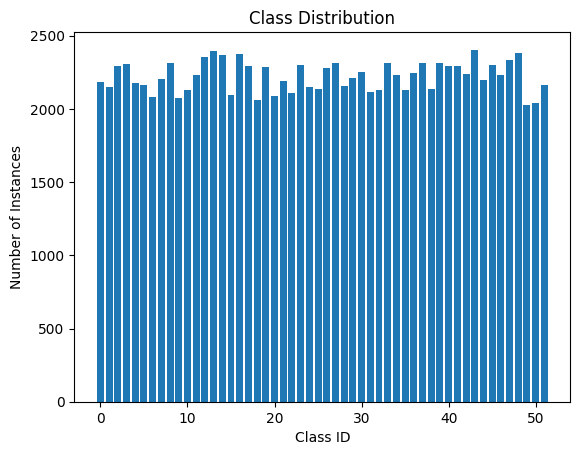

In [ ]:
val_train = count_classes('E:/jn/Project TMS-DS/dop/train/labels')

plt.bar(val_train.keys(), val_train.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()

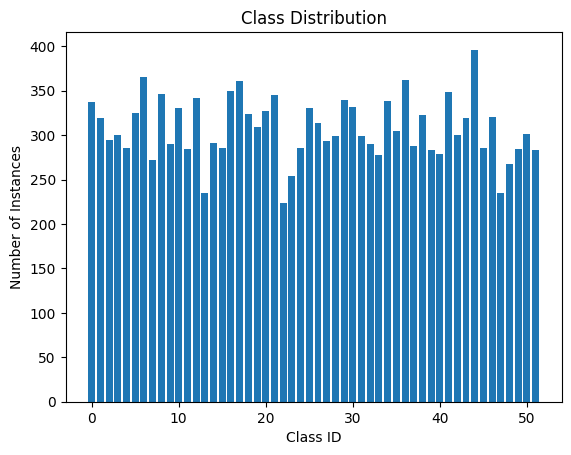

In [ ]:
val_valid = count_classes('E:/jn/Project TMS-DS/dop/valid/labels')

plt.bar(val_valid.keys(), val_valid.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()

# Выбор модели и обучение
После того, как мы подготовили наш файл для обучения, то теперь нам надо выбрать подходящую модель от YOLO. Нам важны такие показатели как точность модели, задержка при работе в реальном времени, не высокая вычислительная сложность модели.

<- Архитектура модели YOLOv10:

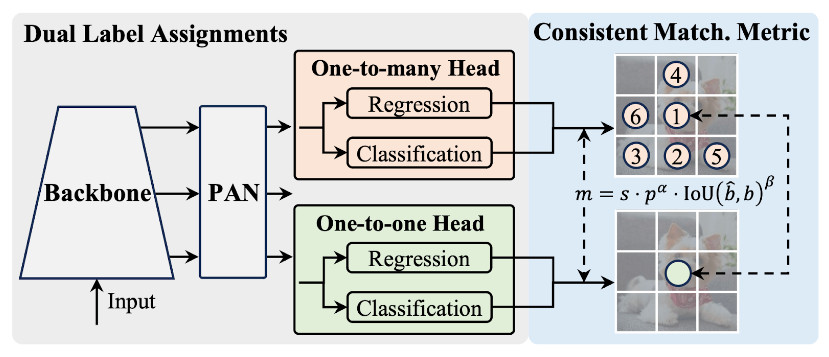

Backbone - отвечает за извлечение признаков, использует улучшеную версию CSPNet(Cross Stage Partiel Network) для улучшения градиентного потока и сниежния вычислительной избыточности.

Neck - объединение признаков из разных мастштабов и передачи их в головую. Включает в себя еще PAN (Path Aggregation Network), PSA (Partial Self-Attention) для эффективного слияния многомасштабных признаков

One-to-Many Head - генерирует несколько прогнозов для каждого объекта во время обучения, чтобы обеспечить расширенные контрольные сигналы и повысить точность обучения.

One-to-One Head - генерирует один наилучший прогноз для каждого объекта во время вывода, чтобы исключить необходимость в NMS(Non-Maximum Suppression), тем самым сокращая задержку и повышая эффективность.

<- Сравнение YOLOv10 с другими моделями от ultralytics:



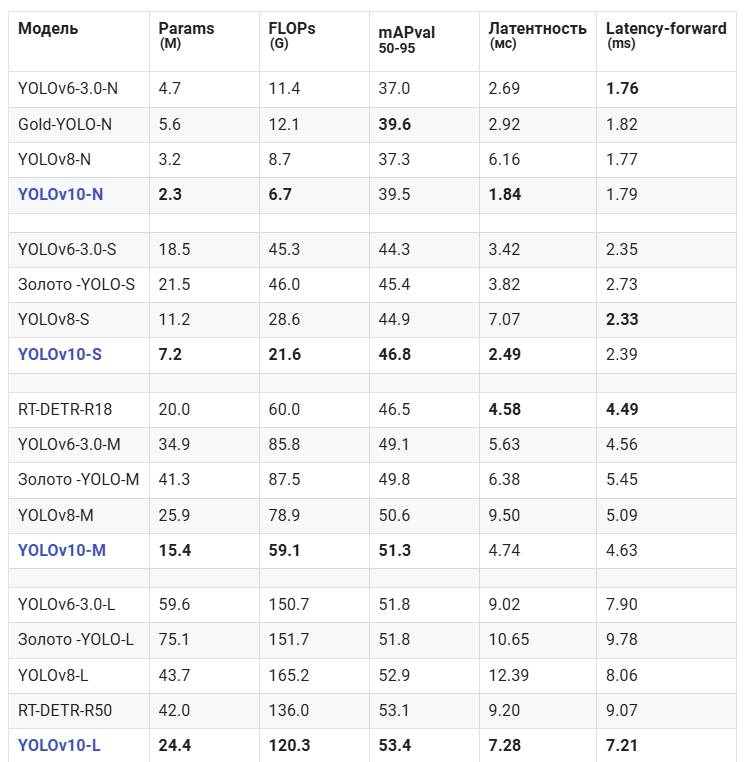

- Params - Количество параметров модели (в миллионах).

* FLOPs - Количество операций с плавающей запятой (в миллиардах, или GFLOPs). Этот показатель указывает на вычислительную сложность модели: чем больше FLOPs, тем больше вычислений требуется для выполнения одного прохода через модель.
* mAP(val) - Средняя точность (Mean Average Precision) на различных порогах IoU (от 50% до 95%). Этот показатель демонстрирует, насколько точно модель распознаёт объекты на тестовых данных.
* Latency - Задержка в миллисекундах, которая включает время на вычисление как прямого, так и обратного прохода модели. Этот показатель важен для реального времени: чем меньше задержка, тем быстрее модель обрабатывает изображения.
* Latency-forward - Время только на прямой проход (вывод), что тоже является важным показателем для работы модели в реальном времени.



Исходя из таблицы мы можем сделать вывод, что лучше всего для этой задачи подойдет YOLOv10s(s). Приступаем к обученю моделей.



In [ ]:
from ultralytics import YOLO

model = YOLO('yolov10s.pt')

model.train(
    data='train_data.yaml',
    epochs=300,
    batch=-1,
    project='runs/train',
    name='yolov10s_8layers_top(main_2)',
    patience=10,
    optimizer= 'Adam',
    freeze = 8
)

Ultralytics 8.3.9  Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov10s.pt, data=train_data.yaml, epochs=300, time=None, patience=10, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=yolov10s_8layers_top, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=8, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'model.4.cv1.bn.weight'
Freezing layer 'model.4.cv1.bn.bias'
Freezing layer 'model.4.cv2.conv.weight'
Freezing layer 'model.4.cv2.bn.weig

train: Scanning E:\jn\Project TMS-DS\dop\train\labels... 28891 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28891


train: New cache created: E:\jn\Project TMS-DS\dop\train\labels.cache


val: Scanning E:\jn\Project TMS-DS\dop\valid\labels... 3993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3993/399


val: New cache created: E:\jn\Project TMS-DS\dop\valid\labels.cache
Plotting labels to runs\train\yolov10s_8layers_top\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0004921875), 111 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\train\yolov10s_8layers_top
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.04G      2.344      3.335      2.083         11        640: 100%|██████████| 4128/4128 [12:09<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.926      0.939      0.984      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.03G      2.027       2.05       1.97         10        640: 100%|██████████| 4128/4128 [11:34<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.975      0.974      0.994      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.12G      1.911       1.81      1.927         13        640: 100%|██████████| 4128/4128 [11:21<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.984      0.988      0.994      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.02G      1.837      1.667      1.904          7        640: 100%|██████████| 4128/4128 [11:24<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.983      0.988      0.994      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.12G        1.8      1.591      1.893         10        640: 100%|██████████| 4128/4128 [11:20<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.988      0.989      0.995      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.03G      1.767       1.53      1.882          8        640: 100%|██████████| 4128/4128 [11:18<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.992      0.992      0.995      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.04G      1.744      1.493      1.874         14        640: 100%|██████████| 4128/4128 [11:19<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.992      0.994      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.02G      1.724      1.456      1.863          3        640: 100%|██████████| 4128/4128 [11:25<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.996      0.995      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.01G       1.71      1.427      1.859          7        640: 100%|██████████| 4128/4128 [11:19<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.996      0.997      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.12G      1.694      1.405      1.856          8        640: 100%|██████████| 4128/4128 [11:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.994      0.996      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.04G      1.683        1.4      1.851         10        640: 100%|██████████| 4128/4128 [11:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.997      0.997      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300       2.1G      1.683       1.38      1.851         12        640: 100%|██████████| 4128/4128 [11:21<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.997      0.998      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.04G       1.67      1.362      1.847          4        640: 100%|██████████| 4128/4128 [11:15<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.997      0.998      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.12G      1.653      1.334      1.841         21        640: 100%|██████████| 4128/4128 [11:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.997      0.998      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.02G      1.648       1.34       1.84          6        640: 100%|██████████| 4128/4128 [11:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.997      0.998      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.02G      1.643      1.335      1.837          1        640: 100%|██████████| 4128/4128 [11:21<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.999      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.04G      1.638       1.32      1.836         17        640: 100%|██████████| 4128/4128 [11:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.03G       1.63      1.303      1.836         12        640: 100%|██████████| 4128/4128 [11:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.997      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.03G      1.627      1.299      1.834          4        640: 100%|██████████| 4128/4128 [11:20<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.997      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.03G      1.628      1.311      1.834          9        640: 100%|██████████| 4128/4128 [11:18<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.999      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.01G      1.628      1.309      1.833         10        640: 100%|██████████| 4128/4128 [11:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.12G      1.622       1.29      1.832          9        640: 100%|██████████| 4128/4128 [11:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.04G      1.614      1.288      1.827         20        640: 100%|██████████| 4128/4128 [11:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300       2.1G      1.616      1.283      1.831          9        640: 100%|██████████| 4128/4128 [11:20<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.04G       1.61      1.279      1.827          7        640: 100%|██████████| 4128/4128 [11:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.04G      1.604      1.271      1.825         11        640: 100%|██████████| 4128/4128 [11:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.999      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300       2.1G      1.597      1.266      1.825          5        640: 100%|██████████| 4128/4128 [11:23<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.03G        1.6      1.266      1.824          4        640: 100%|██████████| 4128/4128 [11:20<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.04G      1.595      1.254      1.821         22        640: 100%|██████████| 4128/4128 [11:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.11G      1.597      1.257      1.824         15        640: 100%|██████████| 4128/4128 [11:23<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.12G      1.588      1.239      1.822         12        640: 100%|██████████| 4128/4128 [11:19<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.02G      1.588      1.246       1.82         16        640: 100%|██████████| 4128/4128 [11:27<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.11G      1.592      1.254      1.822         10        640: 100%|██████████| 4128/4128 [11:19<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.12G      1.581      1.244      1.821         17        640: 100%|██████████| 4128/4128 [11:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.02G      1.578      1.235      1.817         11        640: 100%|██████████| 4128/4128 [11:25<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.11G       1.58      1.248      1.819          8        640: 100%|██████████| 4128/4128 [11:28<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.03G      1.577      1.237      1.817          7        640: 100%|██████████| 4128/4128 [11:29<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.11G      1.571      1.233      1.817          7        640: 100%|██████████| 4128/4128 [11:28<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.03G      1.574      1.229      1.817         14        640: 100%|██████████| 4128/4128 [11:28<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.03G      1.576      1.236      1.818         13        640: 100%|██████████| 4128/4128 [11:29<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.11G      1.576      1.234      1.818          7        640: 100%|██████████| 4128/4128 [11:34<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.998      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.03G      1.569      1.229      1.816          8        640: 100%|██████████| 4128/4128 [11:29<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.03G      1.574      1.237       1.82         13        640: 100%|██████████| 4128/4128 [11:27<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.998      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.04G      1.568      1.227      1.815         23        640: 100%|██████████| 4128/4128 [11:33<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.03G      1.567      1.223      1.816         25        640: 100%|██████████| 4128/4128 [11:33<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.999      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.04G      1.563      1.217      1.815         14        640: 100%|██████████| 4128/4128 [11:32<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:

                   all       3993      15972      0.998      0.998      0.995      0.935
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 36, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



46 epochs completed in 9.464 hours.
Optimizer stripped from runs\train\yolov10s_8layers_top\weights\last.pt, 16.6MB
Optimizer stripped from runs\train\yolov10s_8layers_top\weights\best.pt, 16.6MB

Validating runs\train\yolov10s_8layers_top\weights\best.pt...
Ultralytics 8.3.9  Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 293 layers, 8,075,208 parameters, 0 gradients, 24.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 286/286 [00:


                   all       3993      15972      0.999      0.999      0.995      0.935
                   10C        252        337      0.998          1      0.995      0.939
                   10D        245        319          1      0.996      0.995      0.923
                   10H        205        295          1      0.999      0.995      0.947
                   10S        219        300      0.996          1      0.995      0.944
                    2C        210        286          1      0.998      0.995      0.944
                    2D        231        325          1      0.998      0.995      0.938
                    2H        271        365      0.999          1      0.995      0.944
                    2S        203        272      0.998          1      0.995       0.96
                    3C        240        346      0.998          1      0.995      0.932
                    3D        212        290      0.998          1      0.995      0.938
                    3

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D9C00DFD00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.0

## Полученные метрики


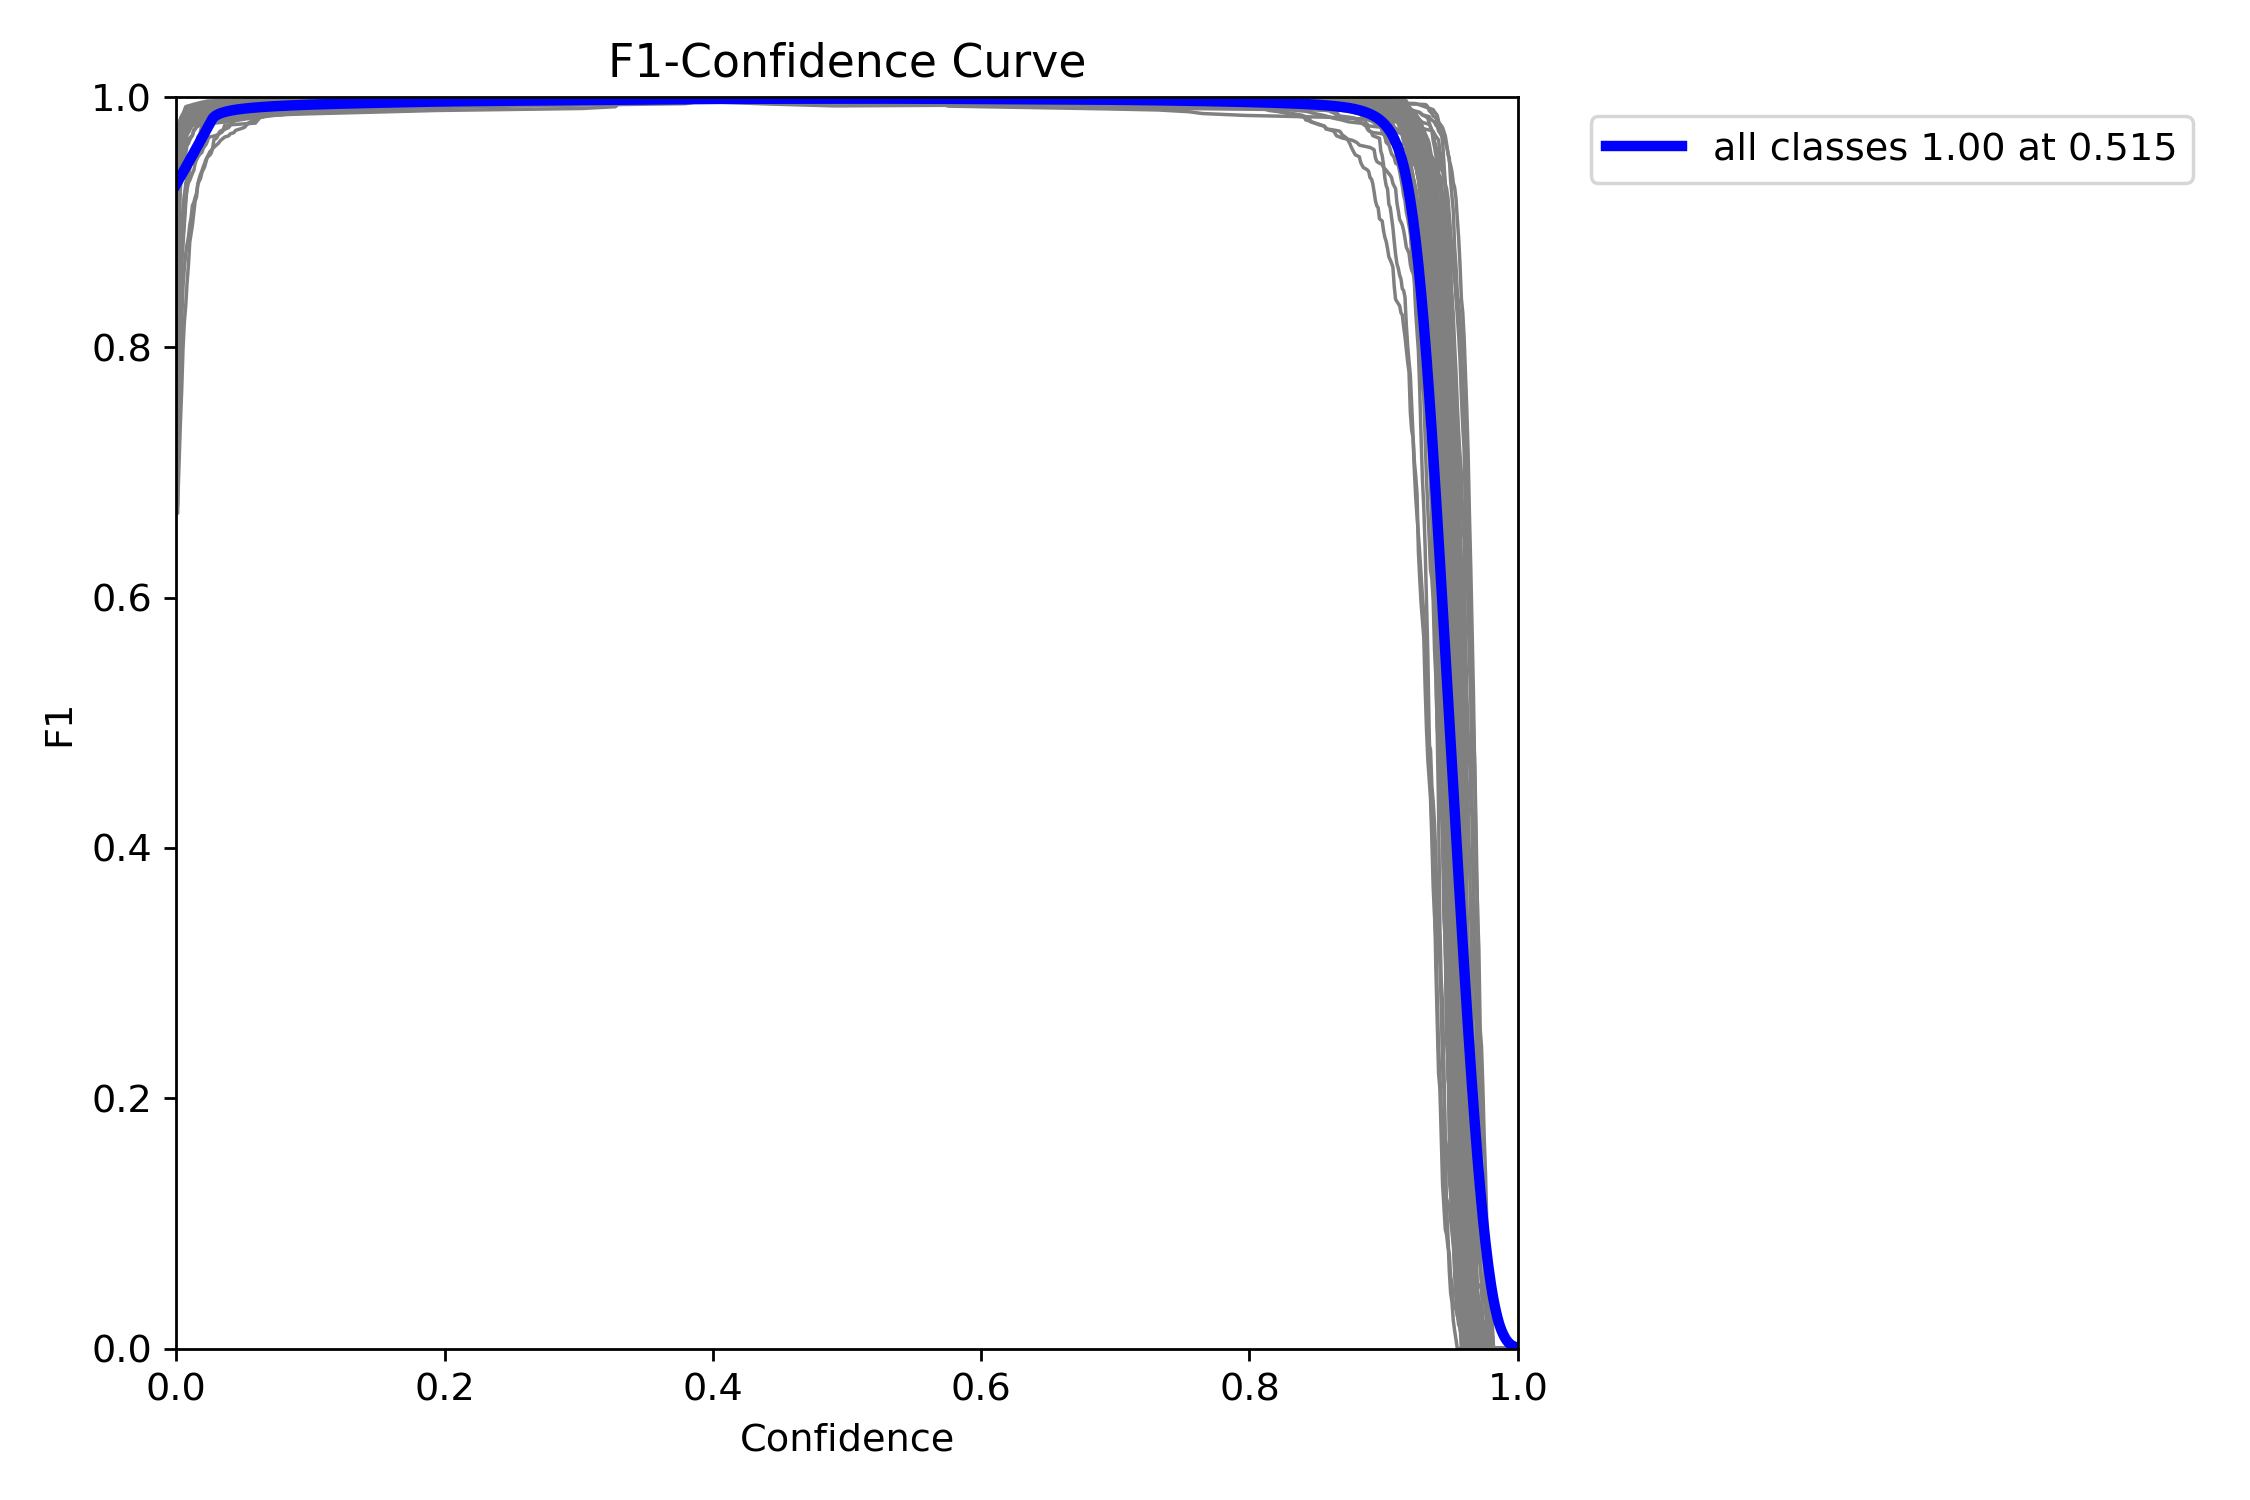

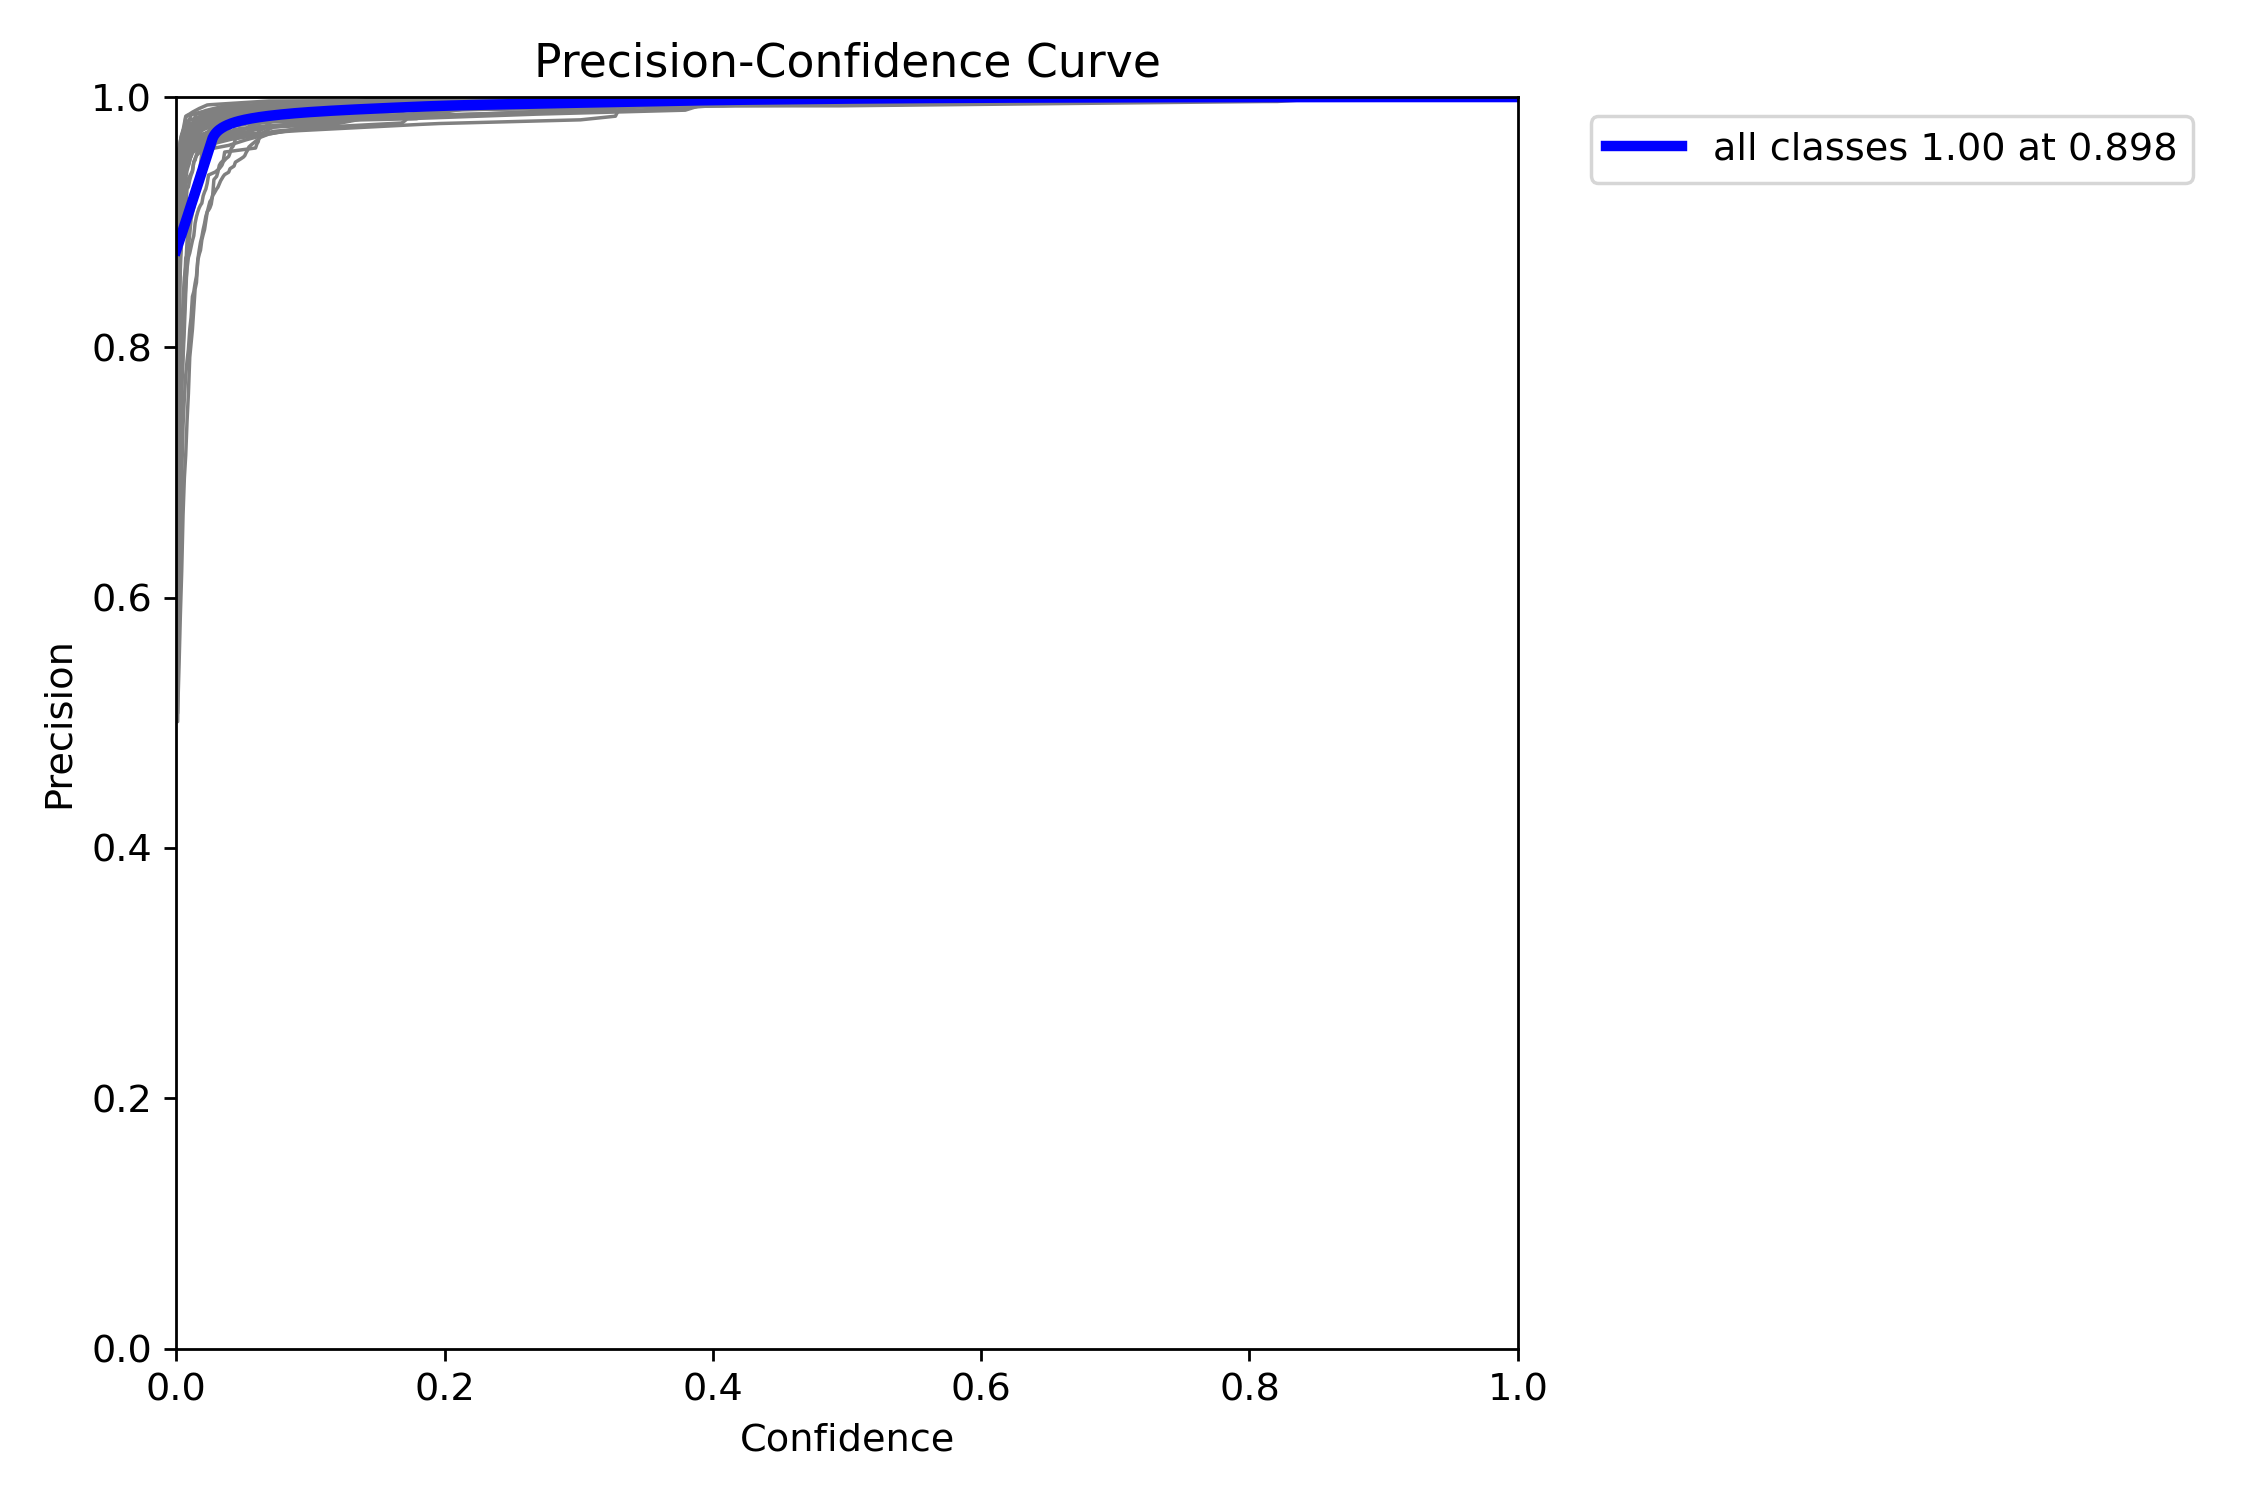


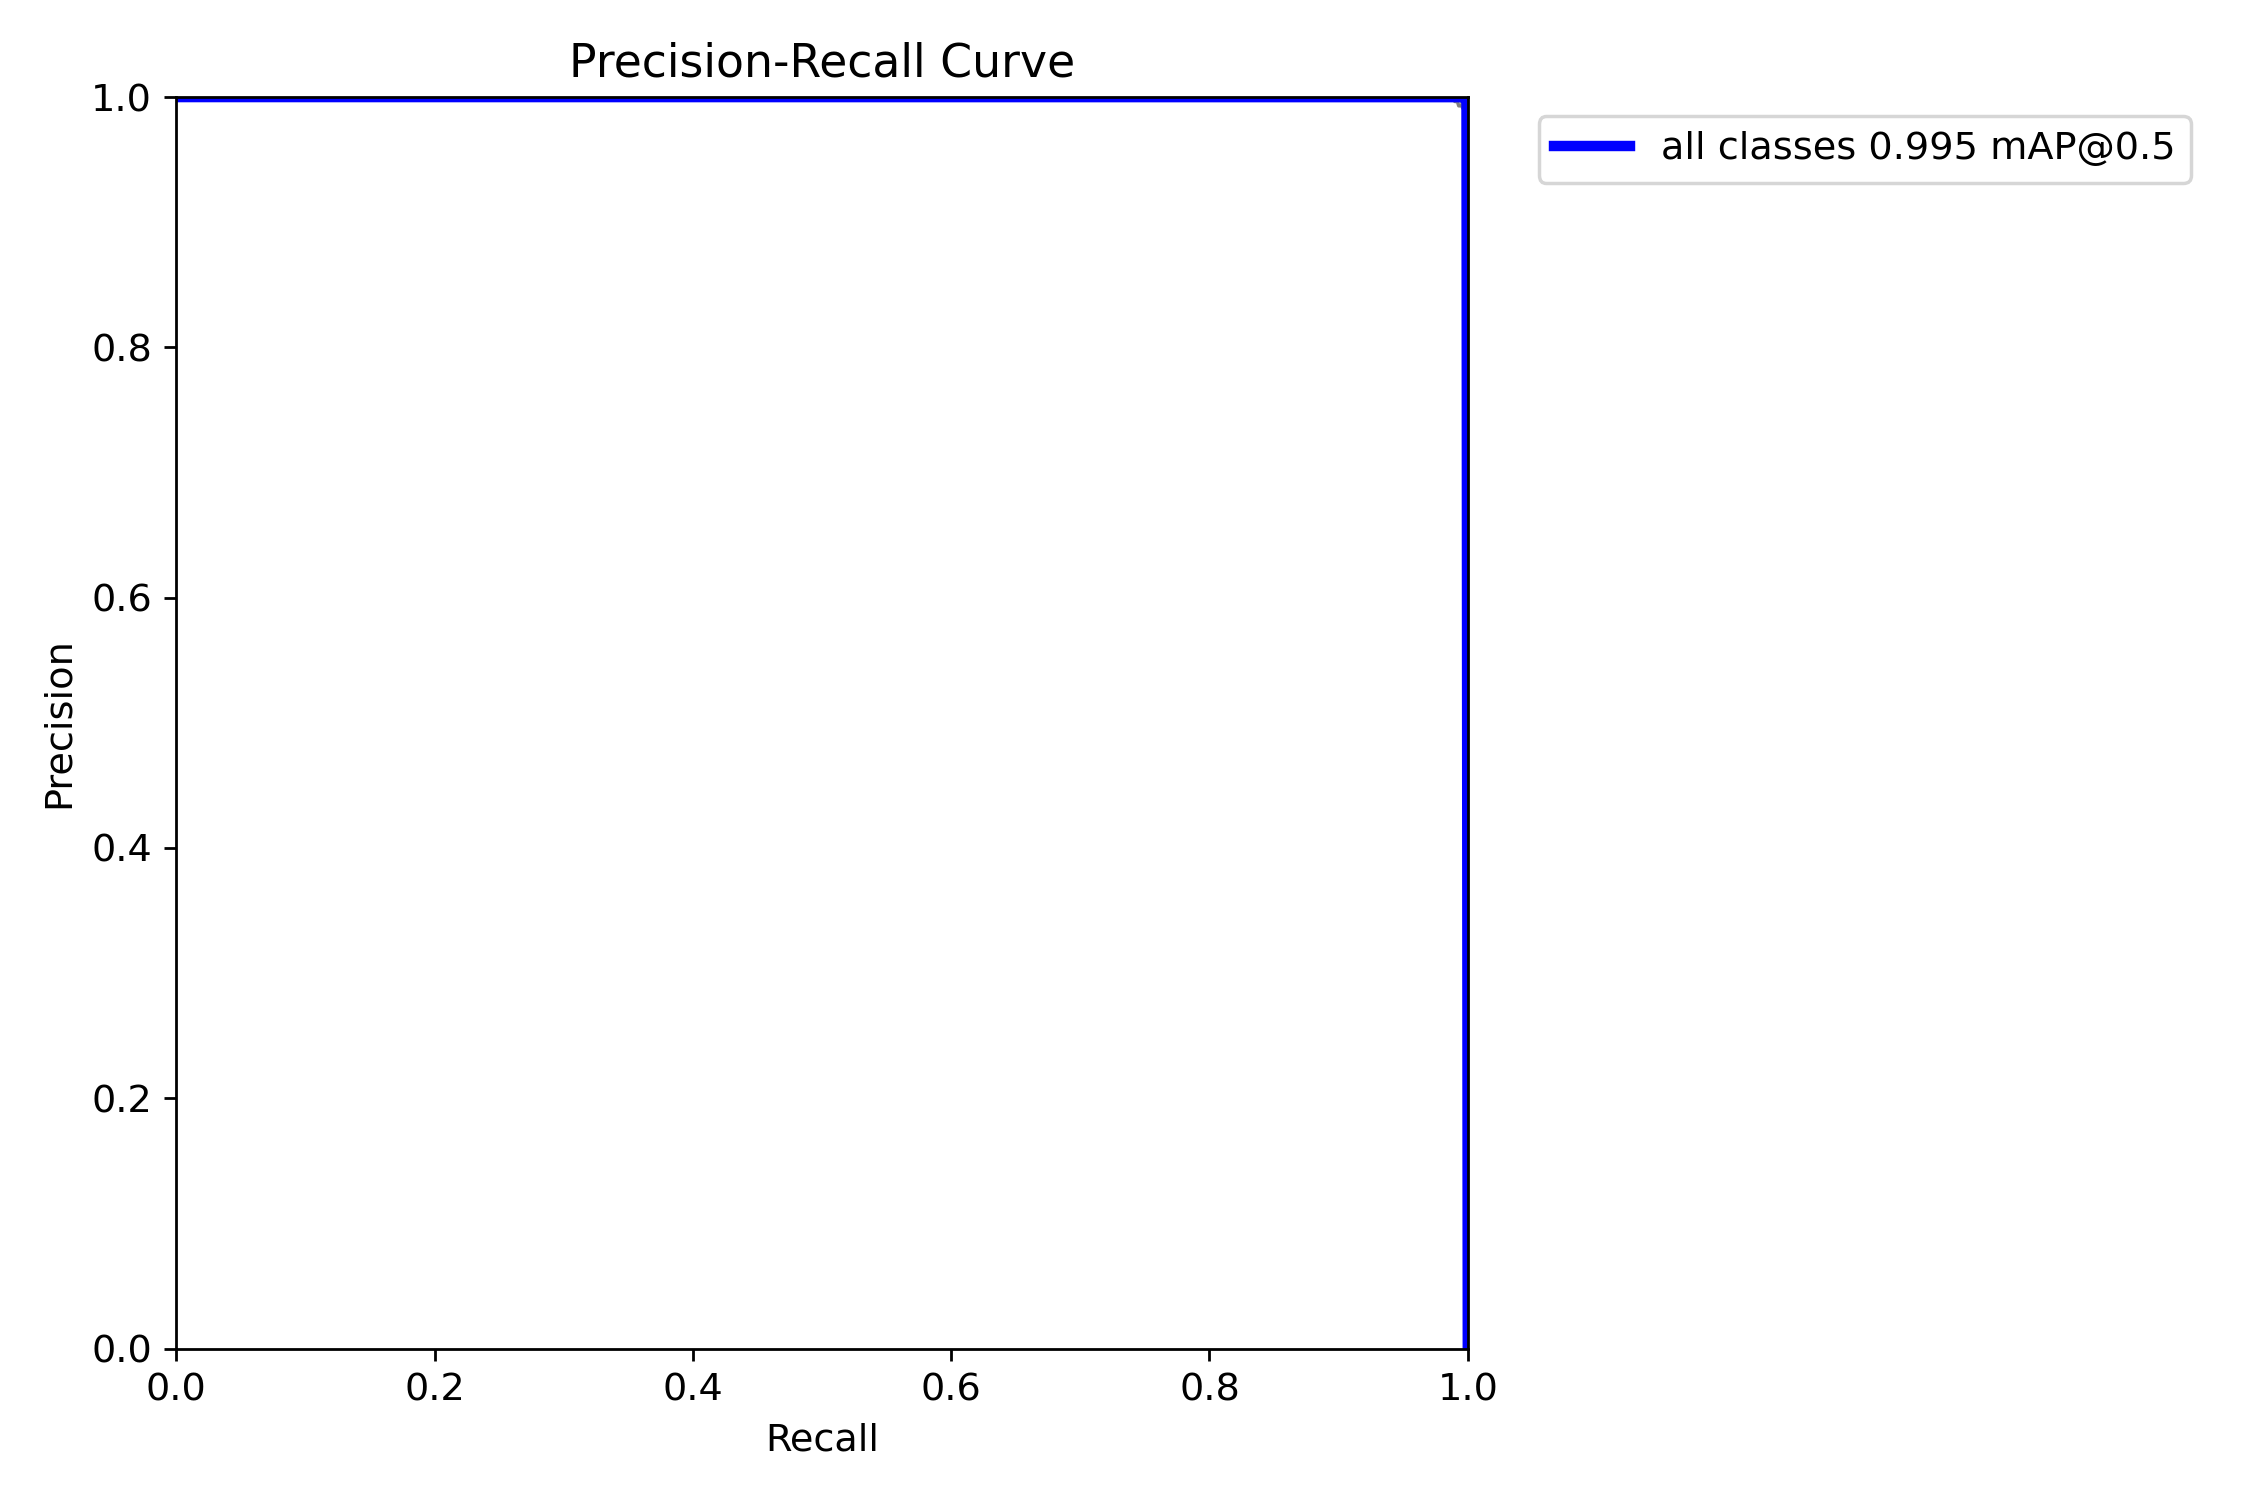


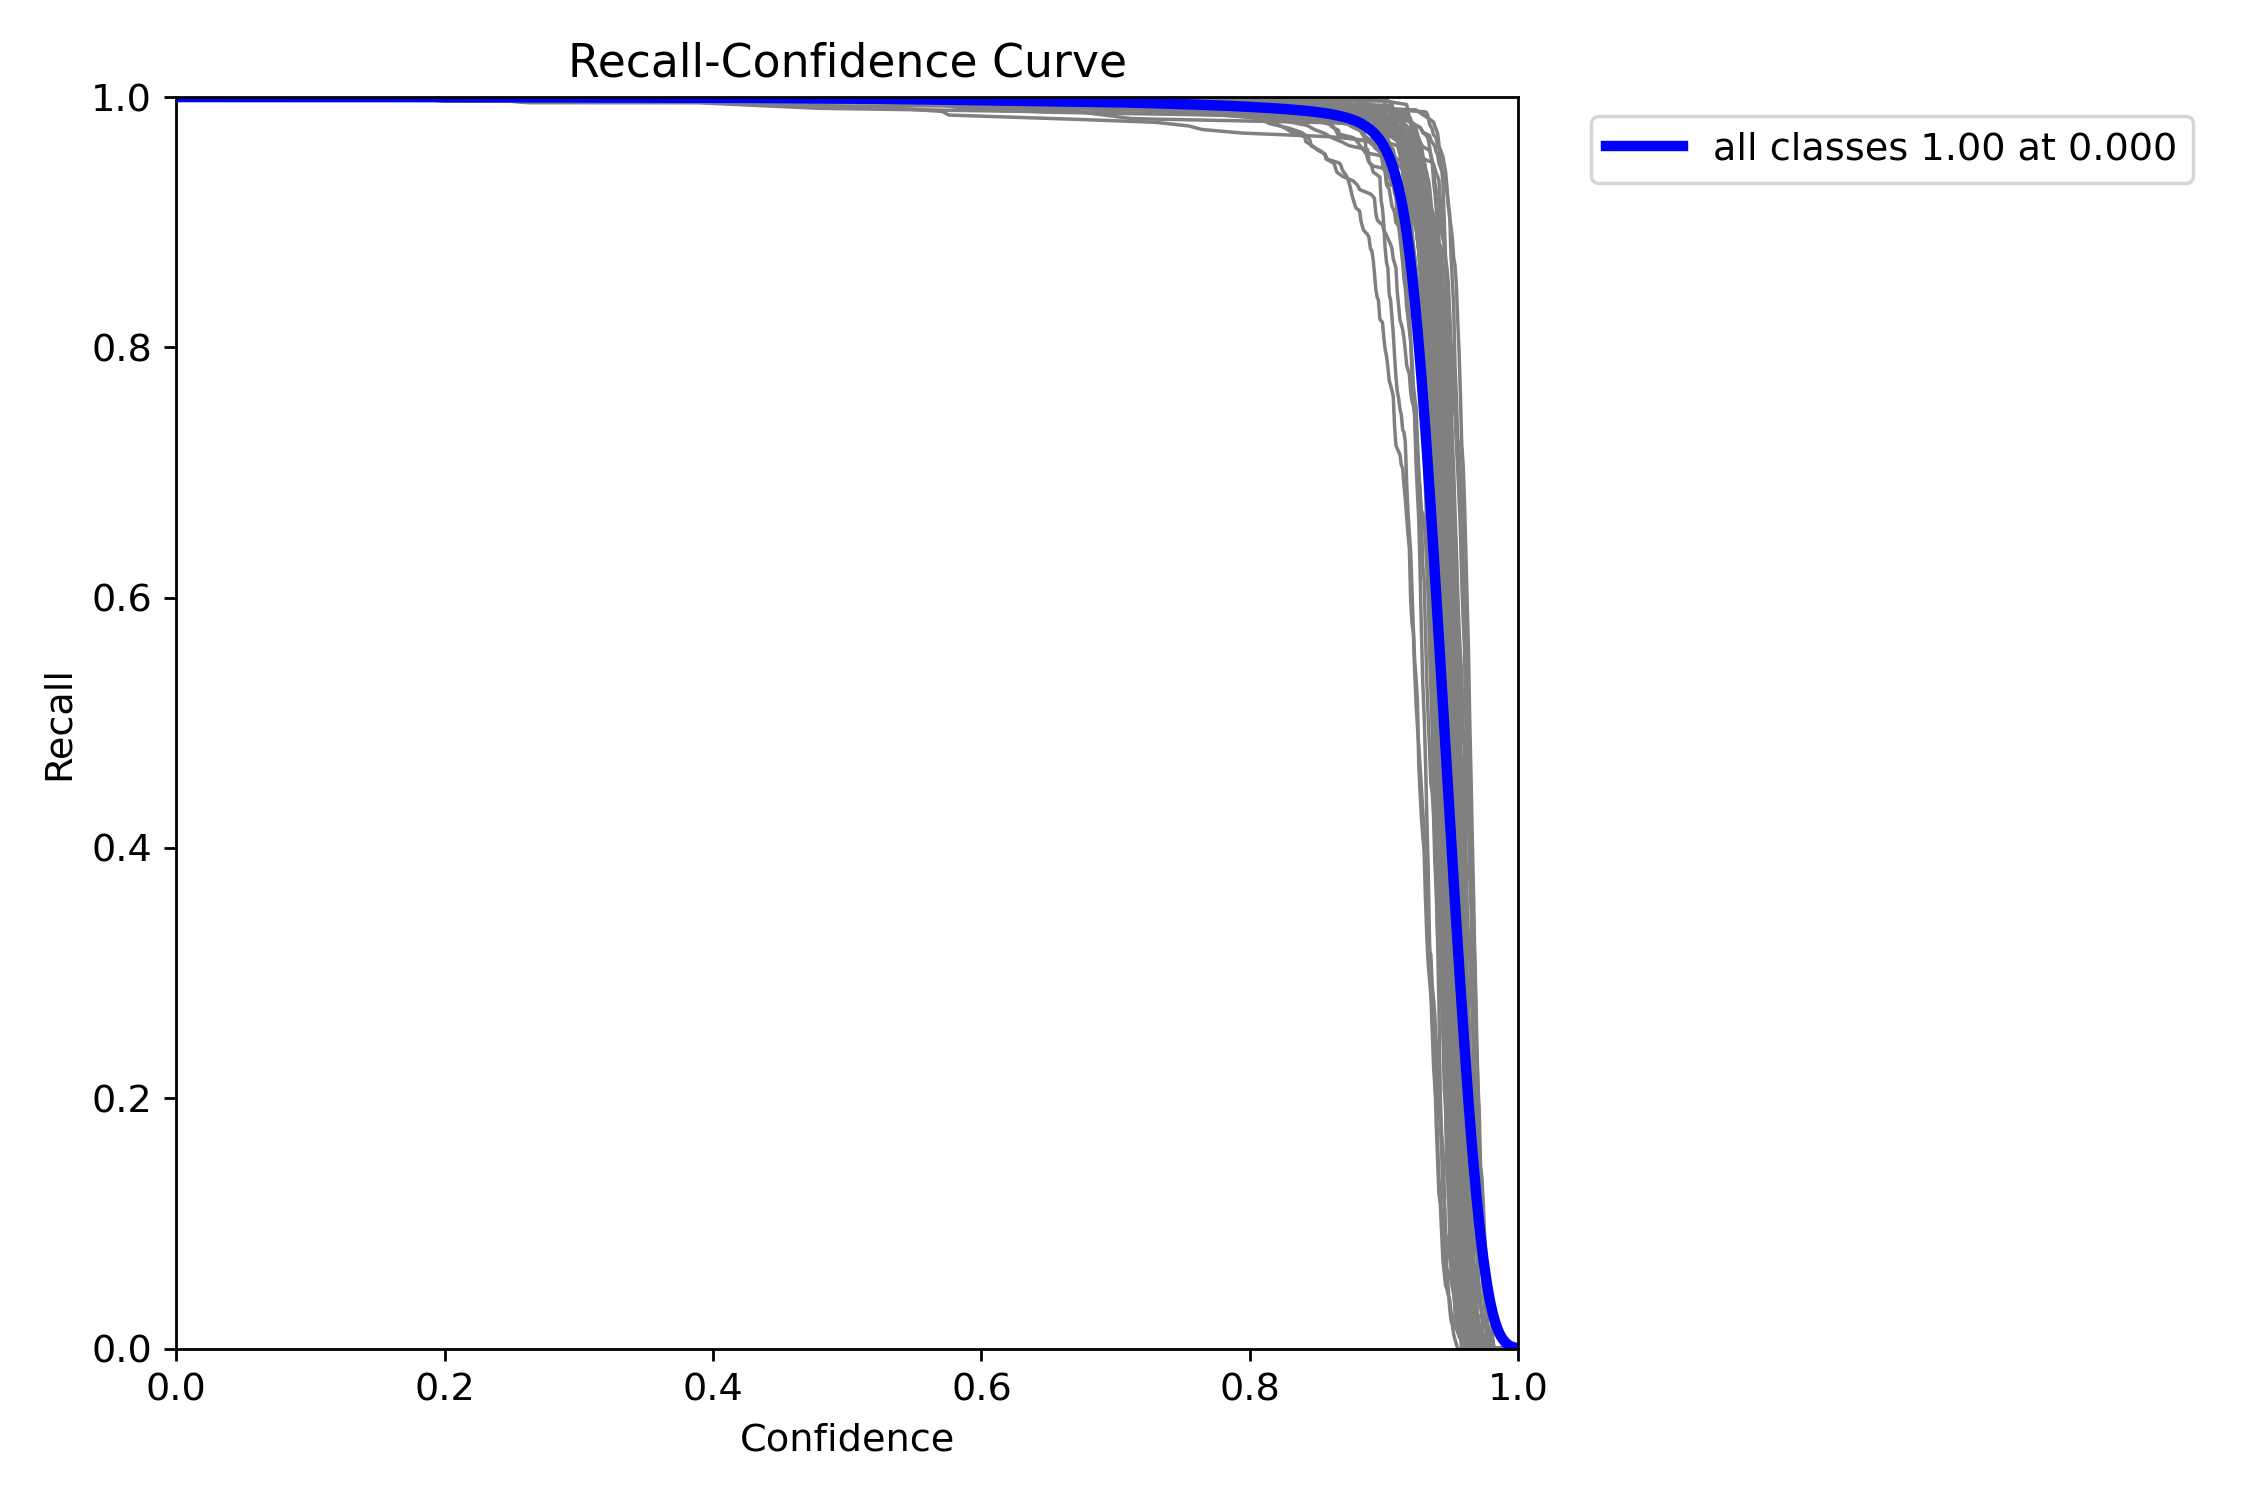


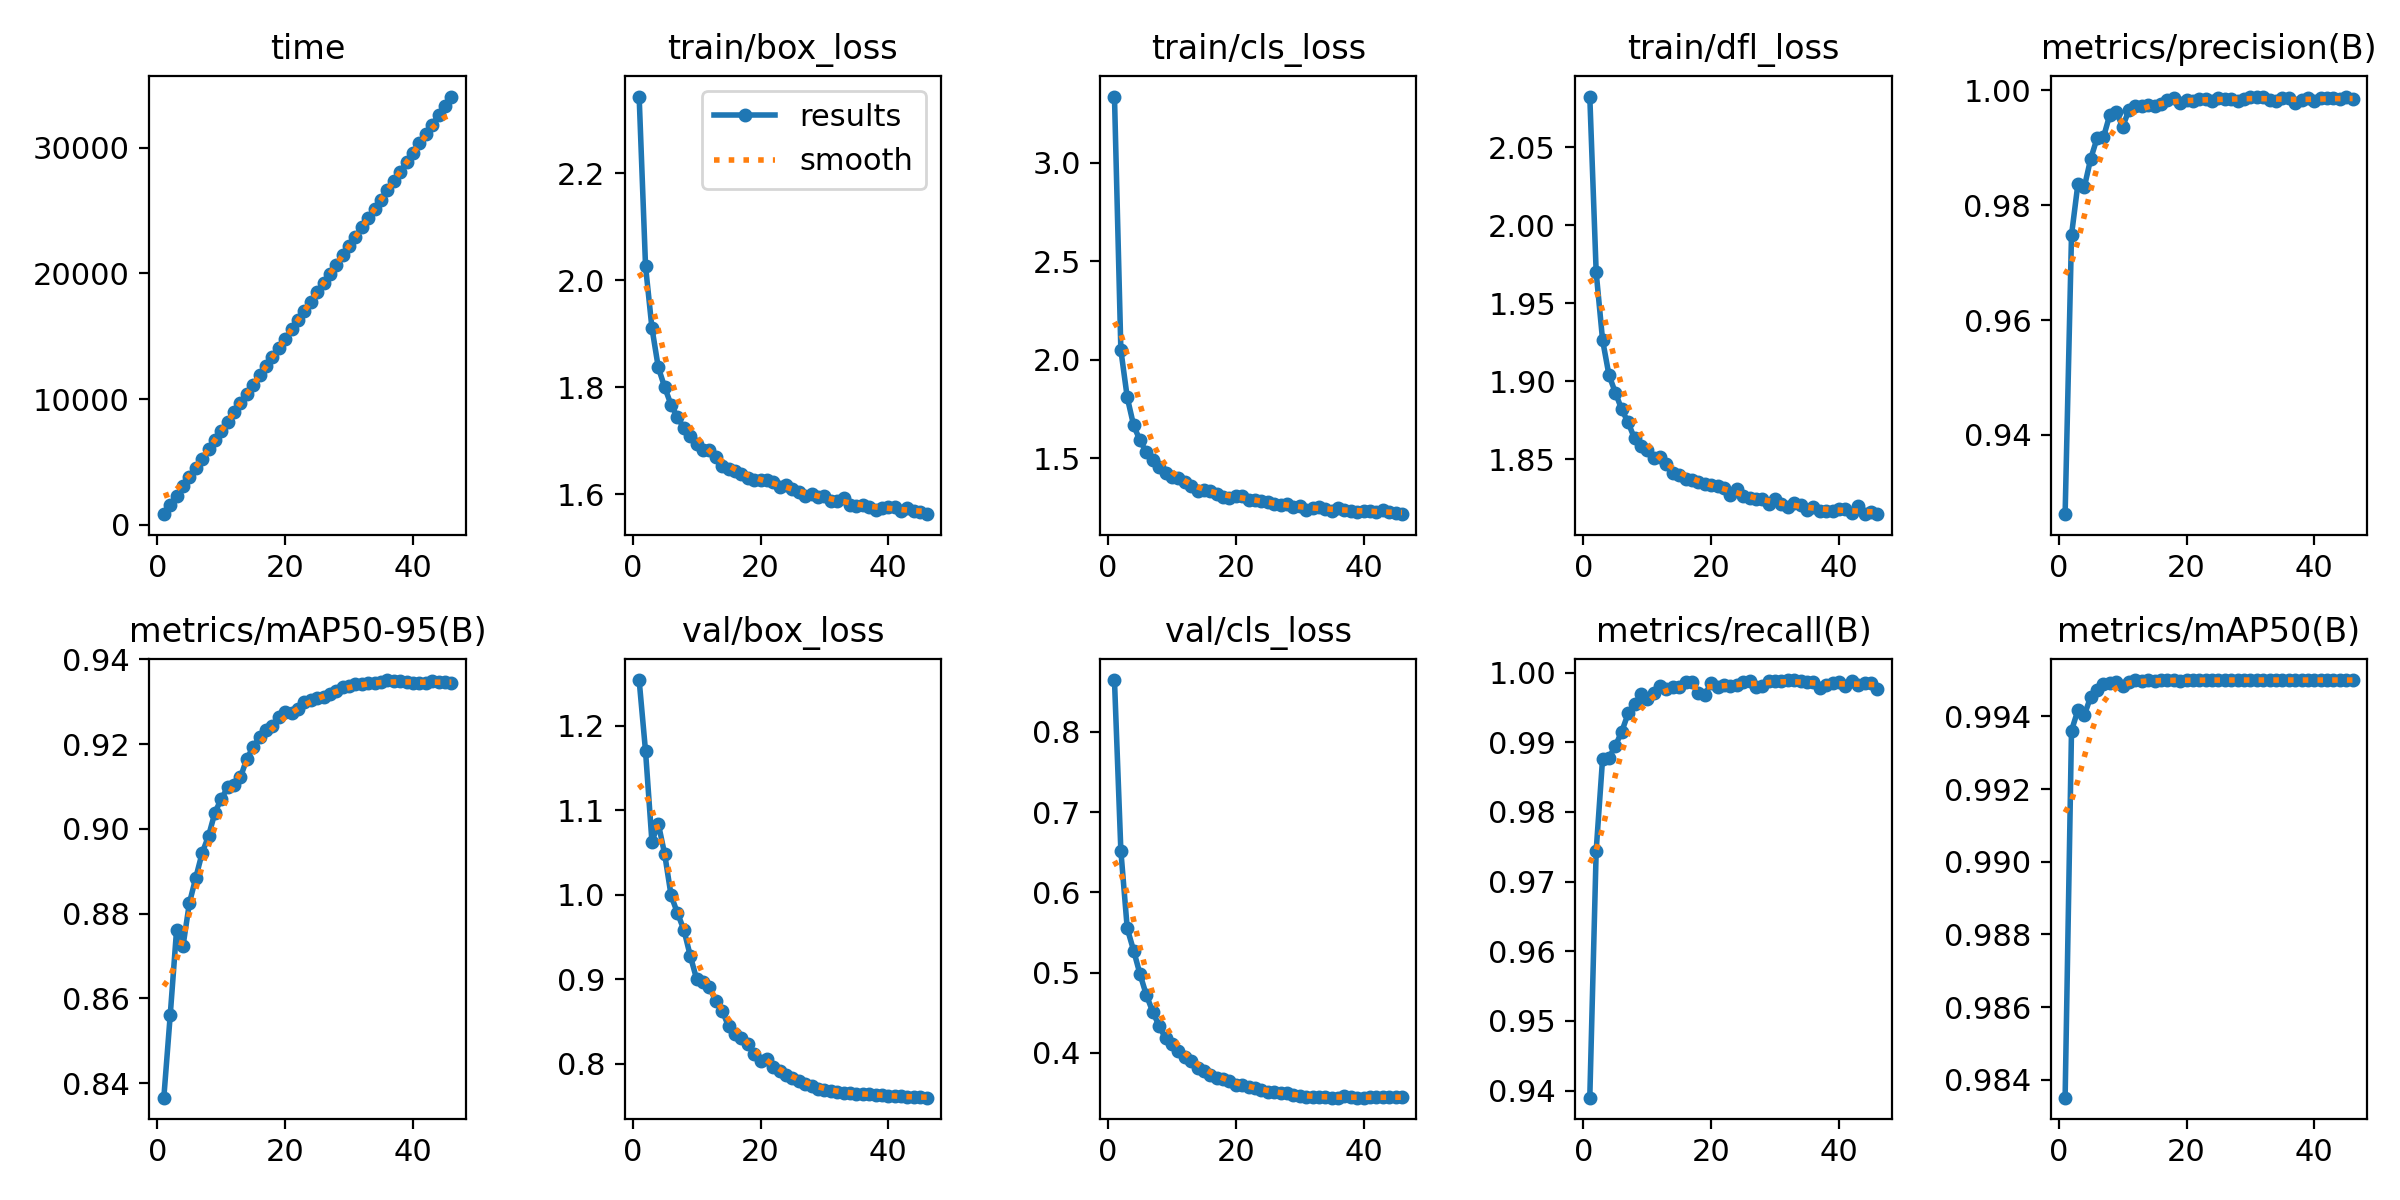


# Блэк-Джэк




Игра в Блэк-Джэк реализована через две камеры. Возможность реализовать через одну реальна, но очень проблематично, так как для игры(игра реализована 1 на 1, диллер и игрок) нужно раздлеять экран на две облости, а через одну камеру, у которой отсутствует фокус, это тяжело. В результате у нас будет две камеры для лучшей реализации игры.

#### Пример работы детекции карт на одной камере

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np

model = YOLO('runs/train/yolov10s_8layers_top(main_2)/weights/best.pt')

# Открываем видео поток с камеры
cap_1 = cv2.VideoCapture(1)

if not cap_1.isOpened():
    print("Не удалось открыть камерy.")
    exit()

while True:
    ret1, frame1 = cap_1.read()
    if not ret1 :
        print("Ошибка при чтении камеры.")
        break

    # Применяем модель к кадру
    results_1 = model(frame1)

    # Отображаем результатыq
    annotated_frame_1 = results_1[0].plot()
    font = cv2.FONT_HERSHEY_SCRIPT_COMPLEX

    cv2.putText(annotated_frame_1, f'Dealer:', (10,30),font, 1,(255,255,255),2,cv2.LINE_AA)

    cv2.imshow('Детекция карт_1', annotated_frame_1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap_1.release()

cv2.destroyAllWindows()

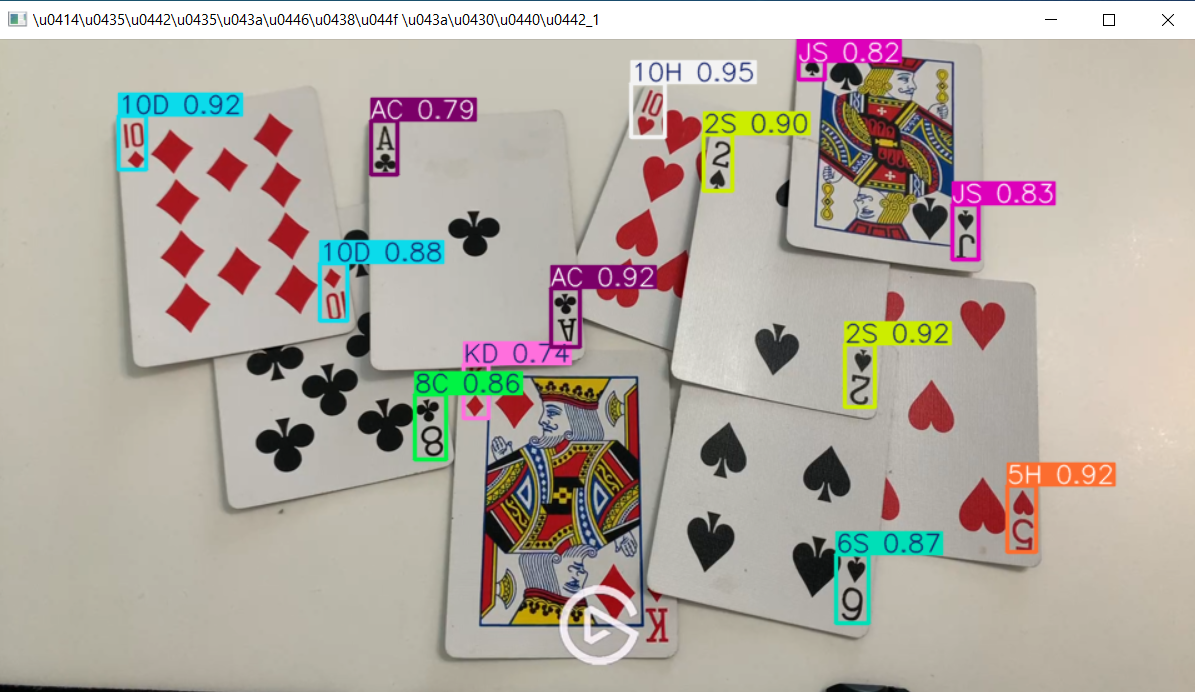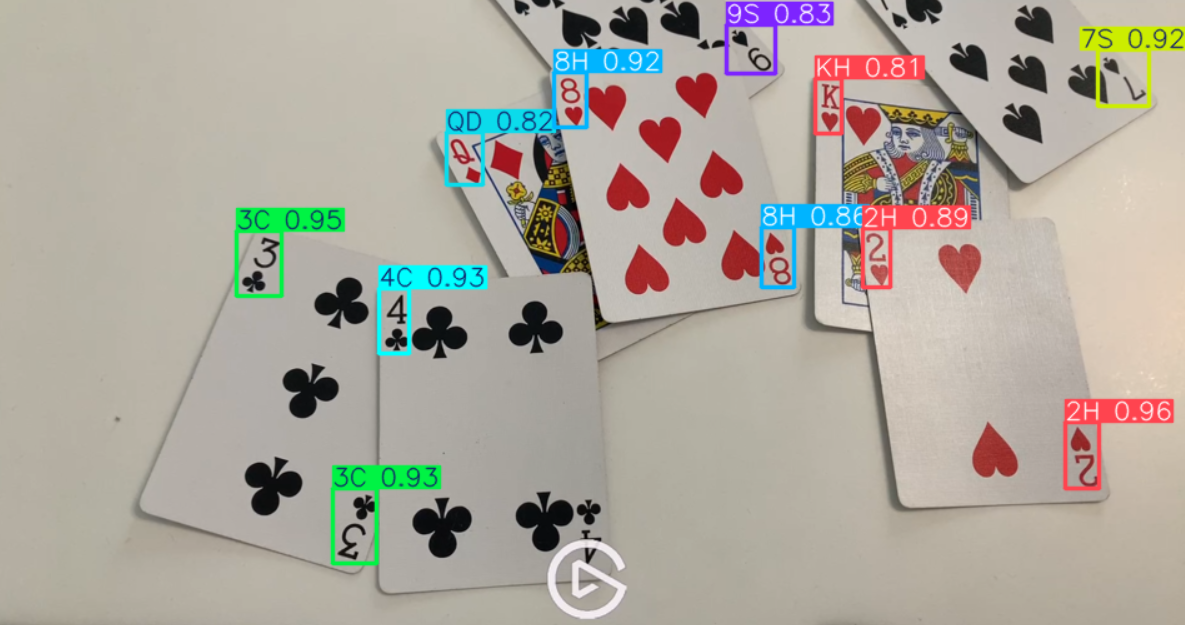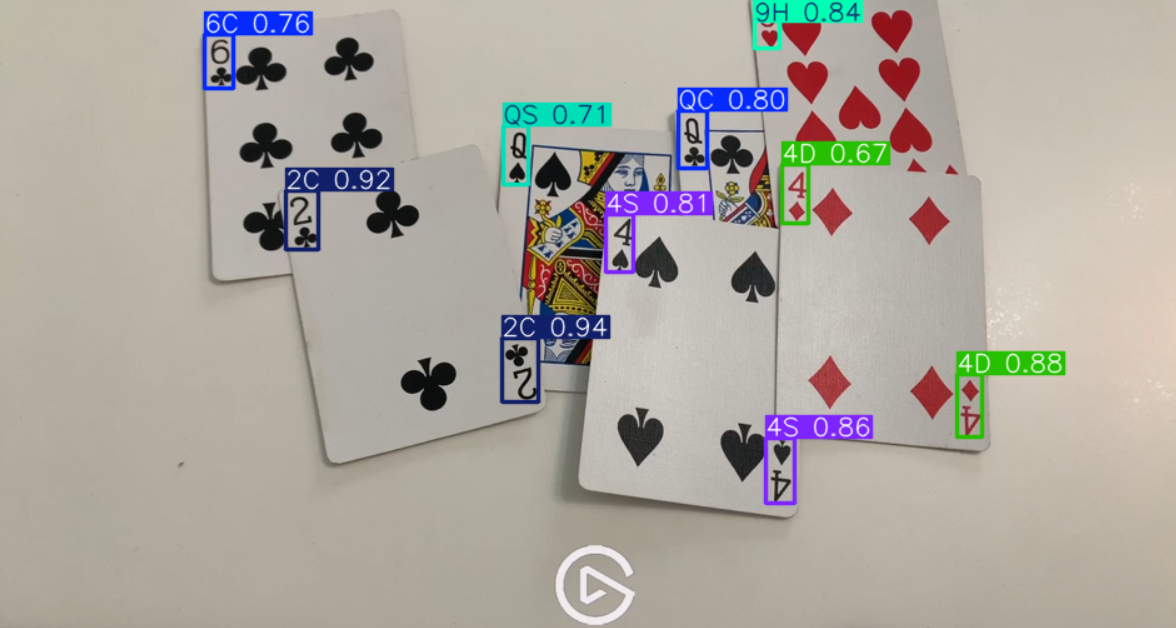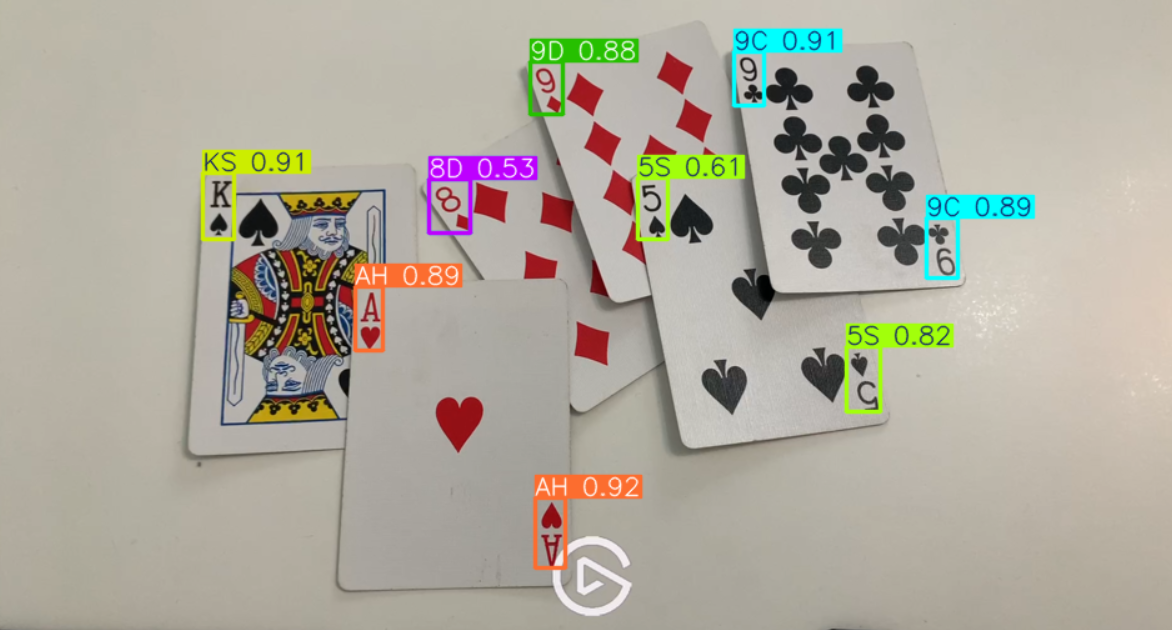

#### Функция подсчета очков


In [ ]:

def counting_cards(class_names : list) -> int:
    class_pred = [card[:-1] for card in class_names]

    num_list = ['2', '3', '4', '5', '6', '7', '8', '9', '10']
    ten_list = ['J', 'K', 'Q']

    rs = 0

    for i in range(len(class_pred)):
        if class_pred[i] in num_list:
            rs+=int(class_pred[i])
        elif class_pred[i] in ten_list:
            rs+=10
        elif class_pred[i]=='A':
            if rs<21:
                rs+=11
            else:
                rs+=1

    return rs

#### Пример подсчета очков на камере

In [ ]:
import cv2
from ultralytics import YOLO

# Загружаем модель
model = YOLO('runs/detect/tmp_n/weights/best.pt')

# Открываем видеоq поток с двух камер
cap_1 = cv2.VideoCapture(1)


if not cap_1.isOpened():
    print("Не удалось открыть одну из камер.")
    exit()

# Шрифт для вывода текста
font = cv2.FONT_HERSHEY_SIMPLEX

while True:
    ret1, frame1 = cap_1.read()
    if not ret1:
        print("Ошибка при чтении с одной из камер.")
        break

    # Применяем модель к кадрам
    results_1 = model(frame1)

    # Для камеры 1
    class_names_1 = [model.names[int(box.cls[0])] for box in results_1[0].boxes]  # Имена классов для каждого объекта
    class_names_1 = list(set(class_names_1))
    annotated_frame_1 = results_1[0].plot()
    res  = counting_cards(class_names_1)

    cv2.putText(annotated_frame_1, f'Dealer: {", ".join(class_names_1)} -> {res}', (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Детекция карт_1 (Dealer)', annotated_frame_1)

    # Ожидаем нажатия клавиши 'q' для выхода
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap_1.release()
cv2.destroyAllWindows()


### Готовый экземпляр


In [ ]:
import cv2
from ultralytics import YOLO

def counting_cards(class_names - list) -> int:
    class_pred = [card[:-1] for card in class_names]

    num_list = ['2', '3', '4', '5', '6', '7', '8', '9', '10']
    ten_list = ['J', 'K', 'Q']

    rs = 0

    for i in range(len(class_pred)):
        if class_pred[i] in num_list:
            rs+=int(class_pred[i])
        elif class_pred[i] in ten_list:
            rs+=10
        elif class_pred[i]=='A':
            if rs<21:
                rs+=11
            else:
                rs+=1

    return rs

# Загружаем модель
model = YOLO('runs/detect/tmp_n/weights/best.pt')

# Открываем видео поток с двух камер
cap_1 = cv2.VideoCapture(0)
cap_2 = cv2.VideoCapture(1)

if not cap_1.isOpened() or not cap_2.isOpened():
    print("Не удалось открыть одну из камер.")
    exit()

# Шрифт для вывода текста
font = cv2.FONT_HERSHEY_SIMPLEX

current_mode = 0
while True:
    ret1, frame1 = cap_1.read()
    ret2, frame2 = cap_2.read()
    if not ret1 or not ret2:
        print("Ошибка при чтении с одной из камер.")
        break

    # Применяем модель к кадрам
    results_1 = model(frame1)
    results_2 = model(frame2)

    # Для камеры 1
    class_names_1 = [model.names[int(box.cls[0])] for box in results_1[0].boxes]  # Имена классов для каждого объекта
    annotated_frame_1 = results_1[0].plot()  # Получаем изображение с аннотациями
    class_names_1 = list(set(class_names_1))
    res_1  = counting_cards(model, class_names_1)

    # Для камеры 2
    class_names_2 = [model.names[int(box.cls[0])] for box in results_2[0].boxes]  # Имена классов для каждого объекта
    annotated_frame_2 = results_2[0].plot()  # Получаем изображение с аннотациями
    class_names_2 = list(set(class_names_2))
    res_2  = counting_cards(model, class_names_2)


    status_1 = ''
    status_2 = ''
    if res_1>res_2 and res_1<21:
        status_1 = 'Win'
        status_2 = 'Lose'
    elif res_2<res_1 and res_2<21:
        status_1 = 'Lose'
        status_2 = 'Win'
    elif res_1>21 and res_2>21:
        if res_1<res_2:
            status_1 = 'Win'
            status_2 = 'Lose'
        else:
            status_1 = 'Lose'
            status_2 = 'Win'
    if res_1==res_2:
        status_1 = 'Push'
        status_2 = 'Push'

    if current_mode==0:
        cv2.putText(frame1, f'Dealer: {", ".join(class_names_1)} -> {res_1}', (10, 30), font, 1, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(frame2, f'Player: {", ".join(class_names_2)} -> {res_2}', (10, 30), font, 1, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow('Детекция карт_1 (Dealer)', frame1)
        cv2.imshow('Детекция карт_2 (Player)', frame2)
    elif current_mode==1:
        cv2.putText(annotated_frame_1, f'Dealer: {", ".join(class_names_1)} -> {res_1}', (10, 30), font, 1, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(annotated_frame_2, f'Player: {", ".join(class_names_2)} -> {res_2}', (10, 30), font, 1, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow('Детекция карт_1 (Dealer)', annotated_frame_1)
        cv2.imshow('Детекция карт_2 (Player)', annotated_frame_2)
    elif current_mode==2:
        cv2.putText(frame1, f'Dealer: {res_1}->{status_1}', (10, 30), font, 1, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(frame2, f'Player: {res_2}->{status_2}', (10, 30), font, 1, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow('Детекция карт_1 (Dealer)', frame1)
        cv2.imshow('Детекция карт_2 (Player)', frame2)

    key = cv2.waitKey(1) & 0xFF
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('a'):
        current_mode = 1
    elif cv2.waitKey(1) & 0xFF == ord('p'):
        current_mode = 2

cap_1.release()
cap_2.release()
cv2.destroyAllWindows()


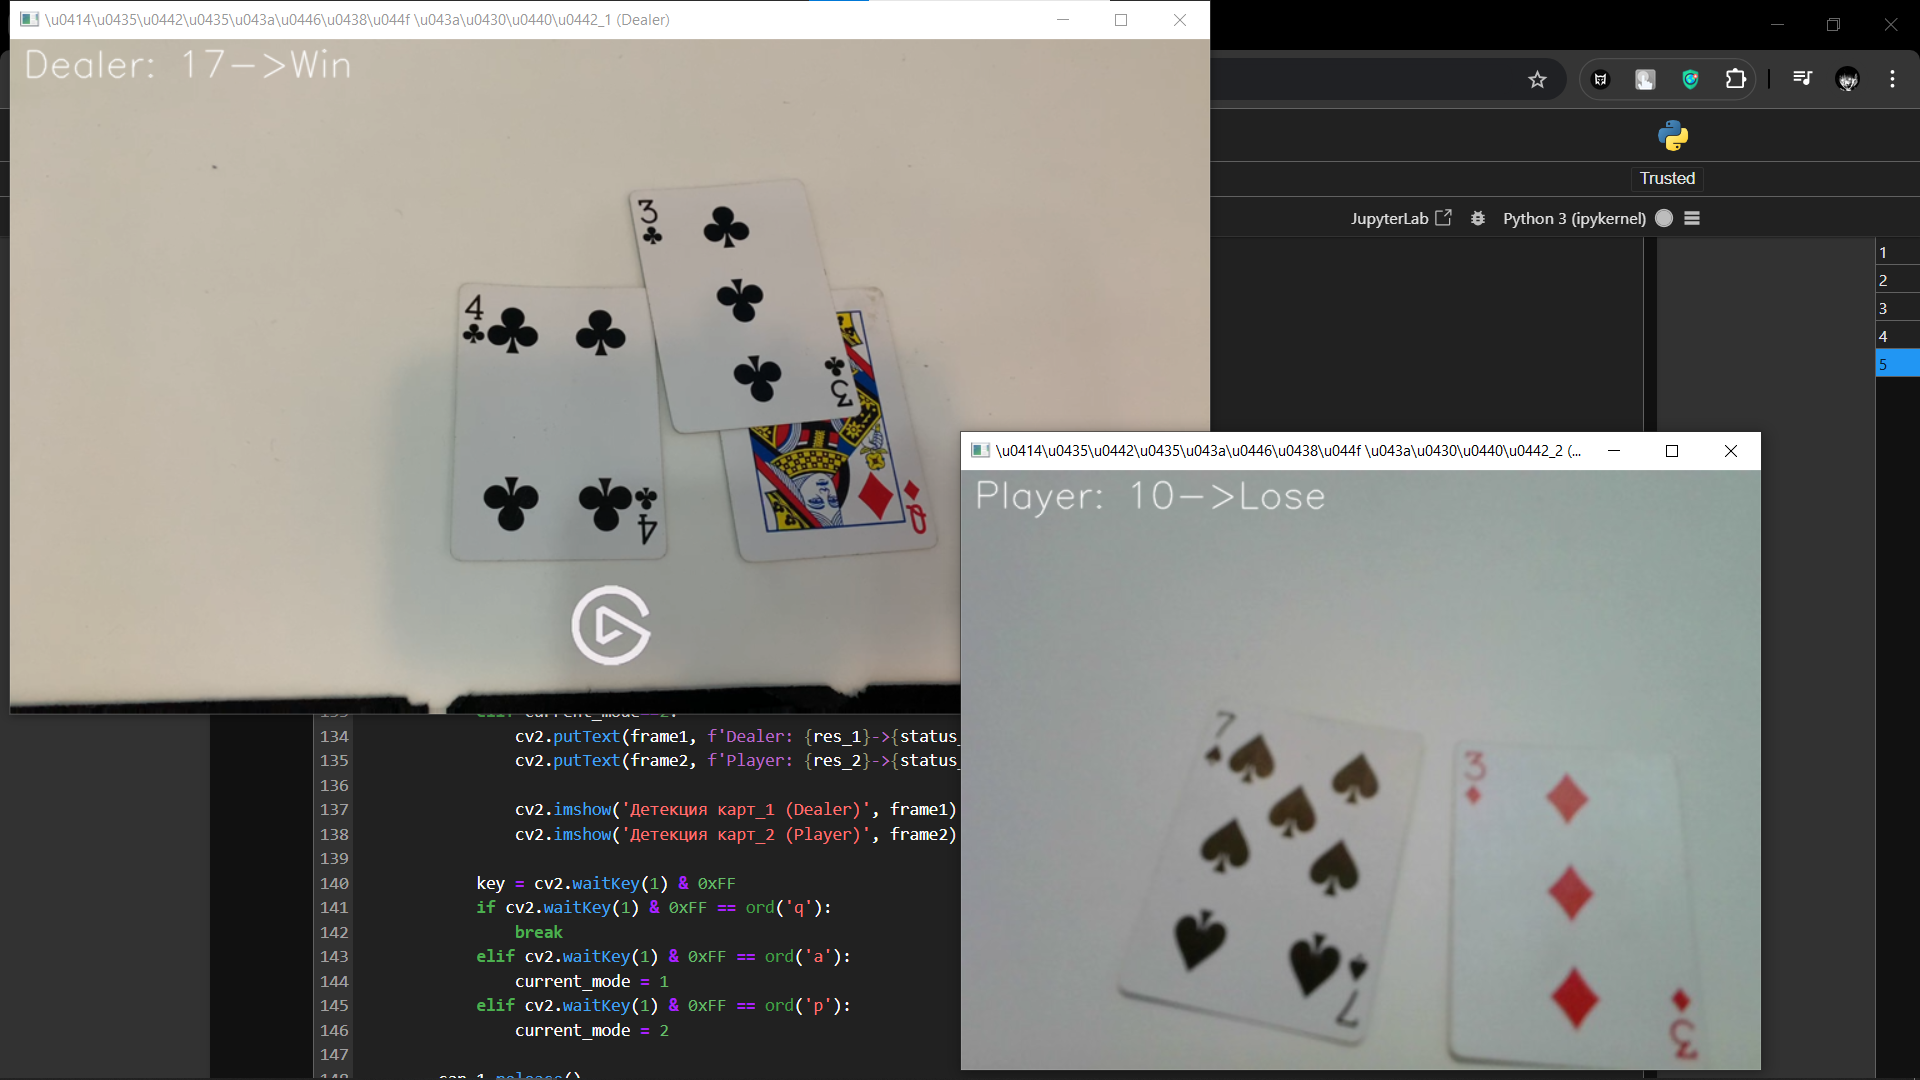

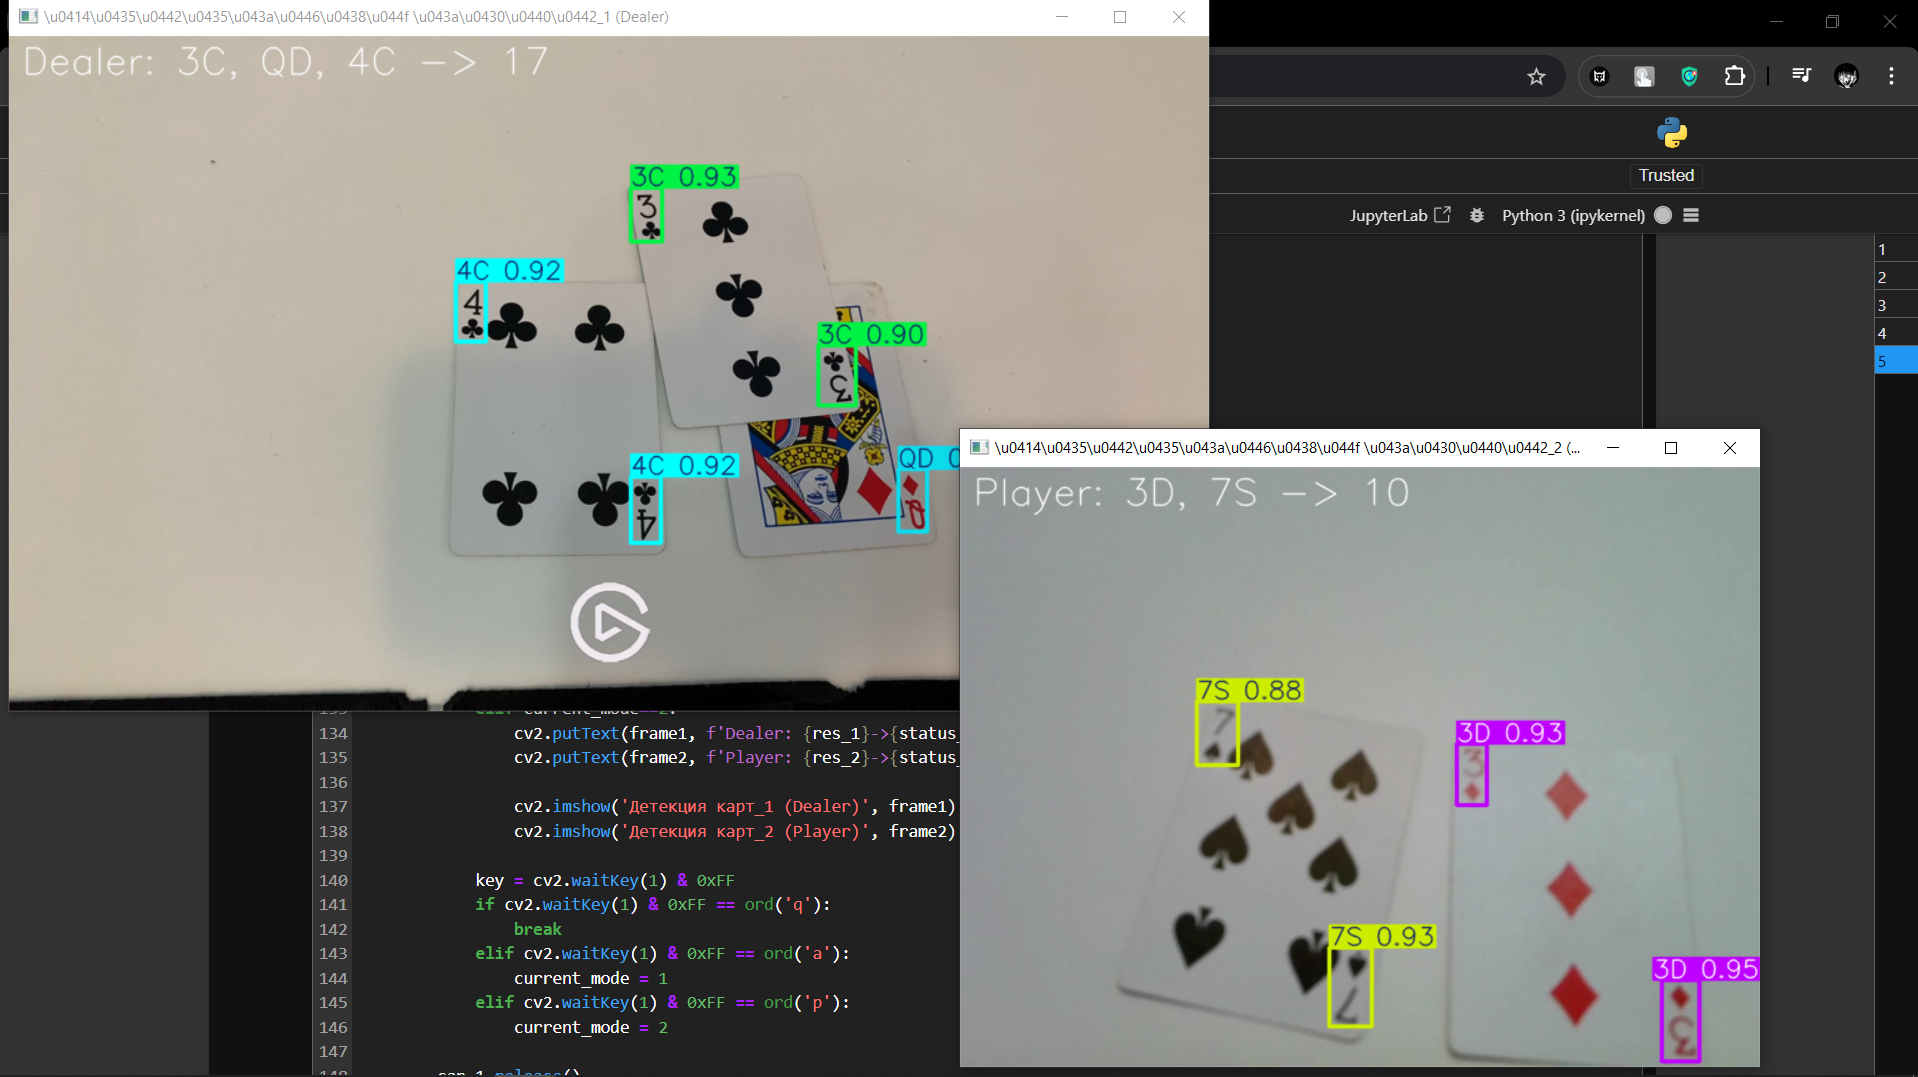

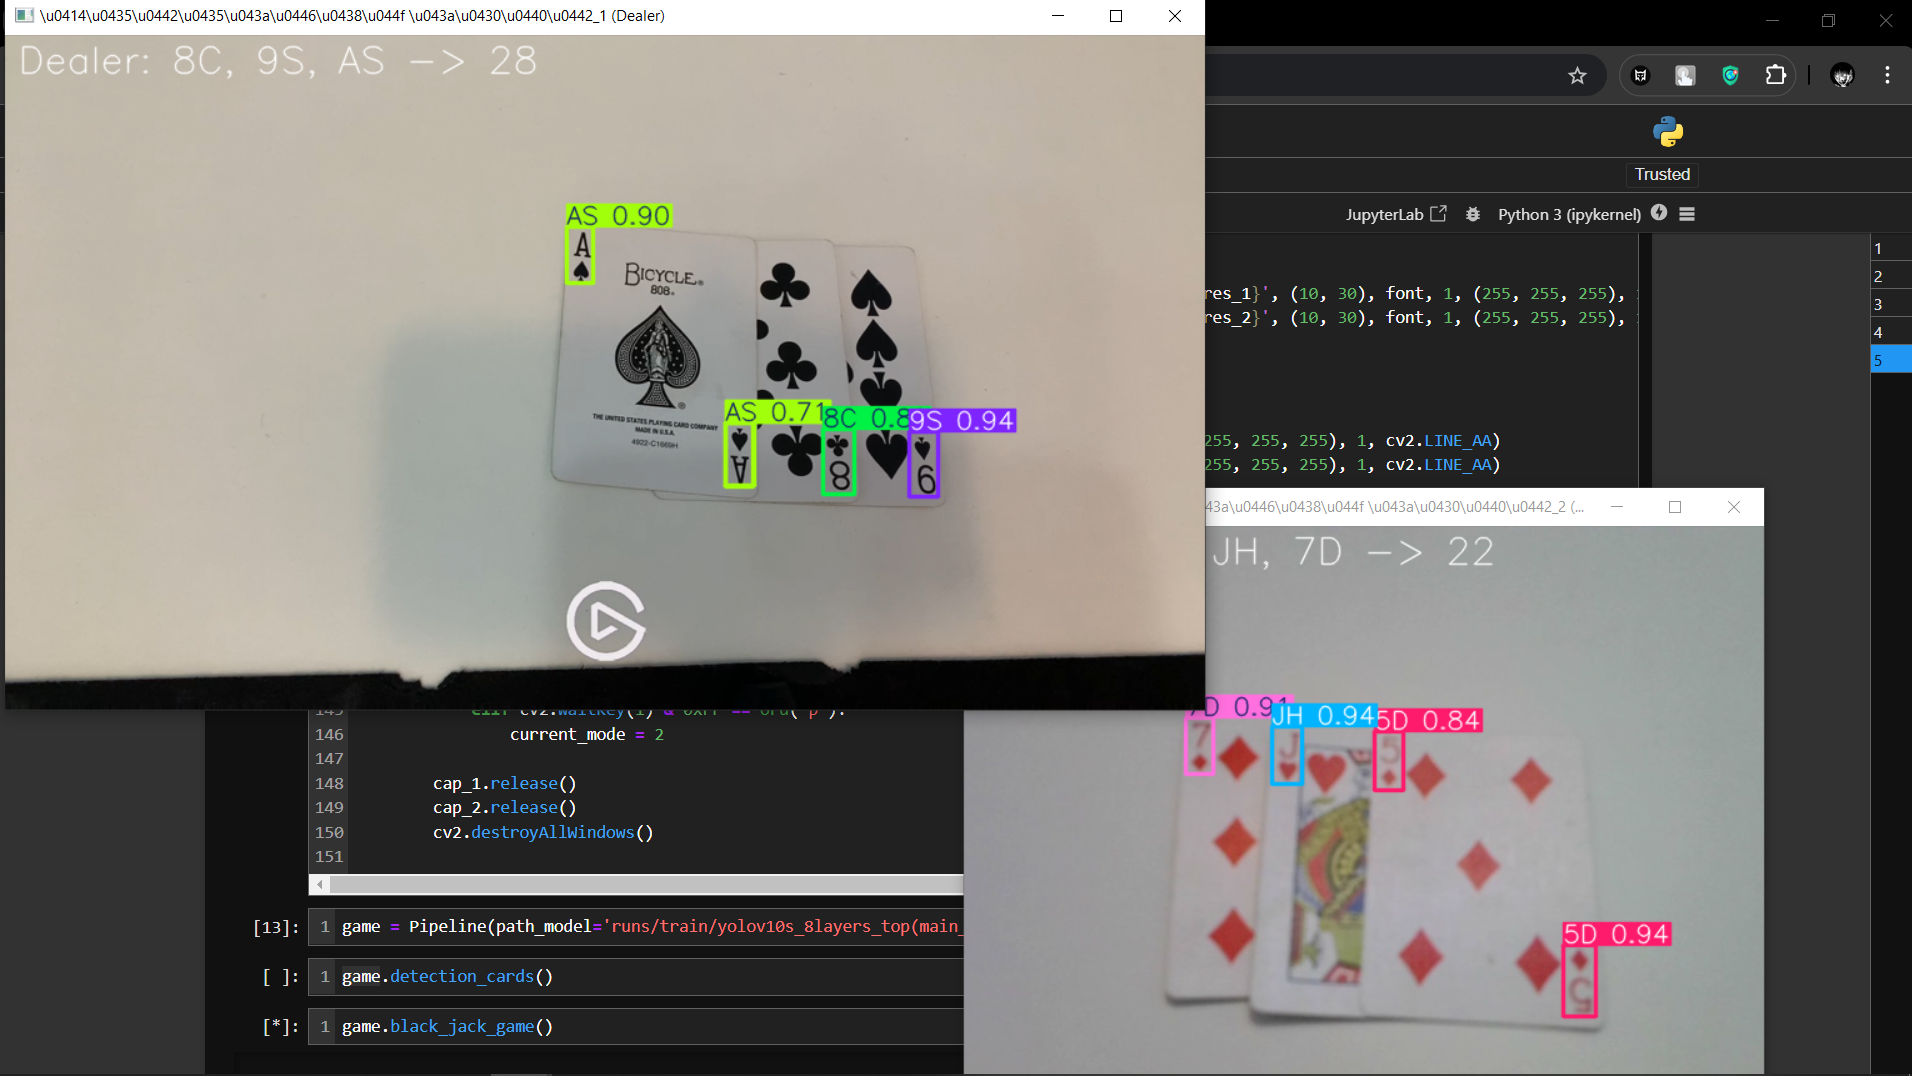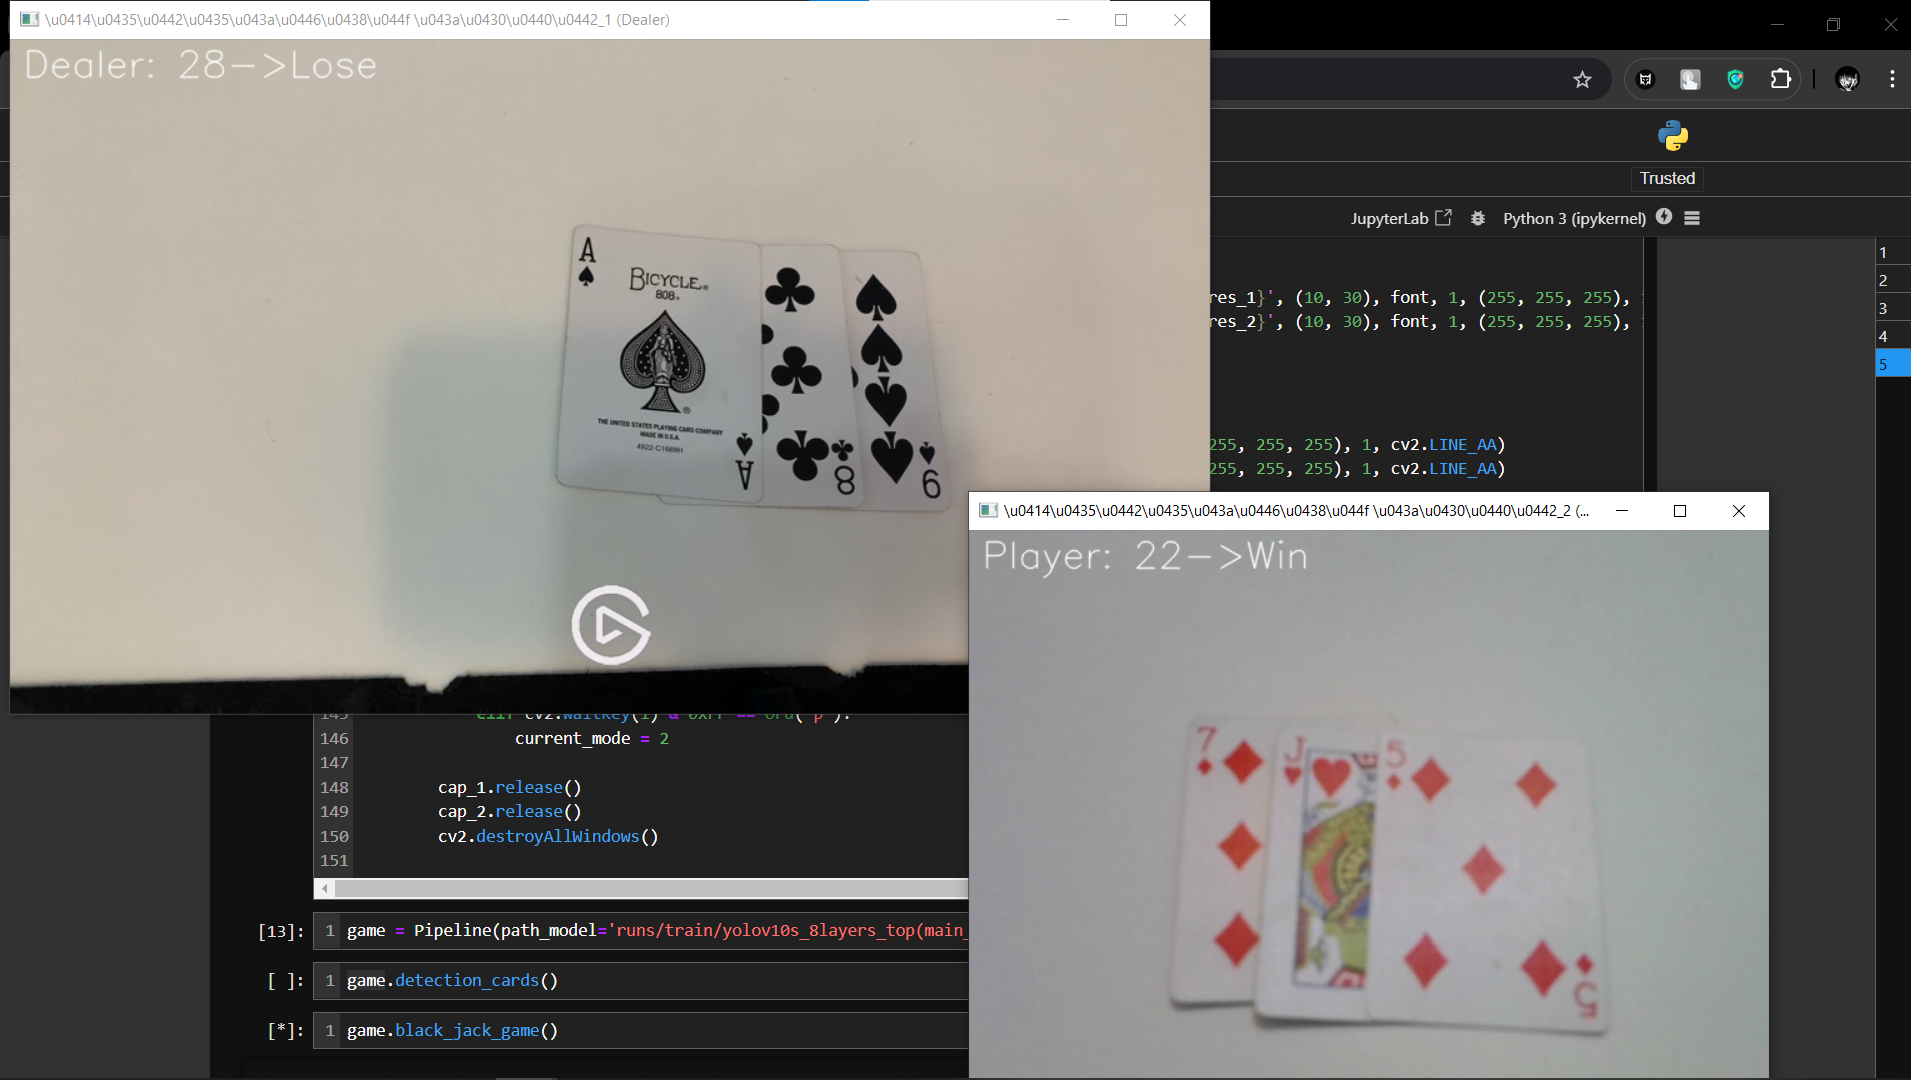